This example assumes you've read `callbacks/basic.ipynb`, and covers:
    - Creating advanced custom callbacks
    - Using and modifying builtin callbacks
    - Visualization, data gathering, and random seed setting callbacks

In [1]:
import os
import sys
from pathlib import Path
os.environ['TF_KERAS'] = '1'
os.environ['SCALEFIG'] = '.8'  # scale all drawn plots by 0.8
sys.path.insert(0, str(Path(Path.cwd()).parents[1]))
sys.path.insert(0, os.path.join(Path(Path.cwd()).parents[2], "see-rnn"))

import os
import sys
import deeptrain
deeptrain.append_examples_dir_to_sys_path()
logger_savedir = os.path.join(sys.path[0], "outputs", "logger")

from utils import make_classifier, init_session, img_labels_paths
from utils import CL_CONFIGS as C
from see_rnn import features_2D

from deeptrain.callbacks import TraingenCallback, TraingenLogger
from deeptrain.callbacks import RandomSeedSetter
from deeptrain.callbacks import make_layer_hists_cb

In [2]:
%config InlineBackend.figure_format = 'retina'  # greatly improve display quality
# increase scrollable window height
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

### Data Logger
  - Gathers data throughout training: weights, outputs, and gradients of model layers. 
  - We inherit the base class and override methods where we wish actions to occur: on save, load, and end of train epoch.

In [3]:
class TraingenLoggerCB(TraingenLogger):
    def __init__(self, savedir, configs, **kwargs):
        super().__init__(savedir, configs, **kwargs)

    def on_save(self, stage=None):
        self.save(_id=self.tg.epoch)  # `tg` will be set inside TrainGenerator

    def on_load(self, stage=None):
        self.clear()
        self.load()

    def on_train_epoch_end(self, stage=None):
        self.log()

log_configs = {
    'weights': ['conv2d'],
    'outputs': 'conv2d',
    'gradients': ('conv2d',),
    'outputs-kw': dict(learning_phase=0),
    'gradients-kw': dict(learning_phase=0),
}
tg_logger = TraingenLoggerCB(logger_savedir, log_configs)

### Outputs visuals
 - Plots model outputs in a heatmap at end of each epoch.
 - Relies on `TraingenLogger` being included in `callbacks`, which stores model outputs so they aren't recomputed for   visualization.
 - All callback objects (except funcs in dicts) are required to subclass `TraingenCallback` (`TraingenLogger` does so)

In [4]:
class Viz2D(TraingenCallback):
    def on_val_end(self, stage=None):
        if stage == ('val_end', 'train:epoch') and (self.tg.epoch % 2) == 0:
            # run `viz` within `TrainGenerator._on_val_end`,
            # and on every other epoch
            self.viz()

    def viz(self):
        data = self._get_data()
        features_2D(data, tight=True, title=False, cmap='hot',
                    norm=None, show_xy_ticks=[0, 0], w=1.1, h=.55, n_rows=4)

    def _get_data(self):
        lg = None
        for cb in self.tg.callbacks:
            if isinstance(cb, TraingenLogger):
                lg = cb
        if lg is None:
            raise Exception("TraingenLogger not found in `callbacks`")

        last_key = list(lg.outputs.keys())[-1]
        outs = list(lg.outputs[last_key][0].values())[0]
        sample = outs[0]                  # (width, height, channels)
        return sample.transpose(2, 0, 1)  # (channels, width, height)

viz2d = Viz2D()

Callbacks can also be configured as str-function dict pairs, where str is name of a callback "stage" 
(see `tg._cb_alias after tg.train()`).

In [5]:
grad_hists = {'train:epoch': [make_layer_hists_cb(mode='gradients:outputs'),
                              make_layer_hists_cb(mode='gradients:weights')]}
weight_hists = {('val_end', 'train:epoch'): make_layer_hists_cb(mode='weights')}

configs = {'title': dict(fontsize=13), 'plot': dict(annot_kw=None)}
outputs_hists = {'val_end': make_layer_hists_cb(mode='outputs', configs=configs)}

### Random seed setter
Sets new random seeds (`random`, `numpy`, TF-graph, TF-global) every epoch, incrementing by 1 from start value (default 0)

In [6]:
seed_setter = RandomSeedSetter(freq={'train:epoch': 2})

### Init & train

In [7]:
C['traingen']['callbacks'] = [seed_setter, tg_logger, viz2d,
                              grad_hists, weight_hists, outputs_hists]
C['traingen']['epochs'] = 4
C['datagen']['labels_path']     = img_labels_paths[0]
C['val_datagen']['labels_path'] = img_labels_paths[1]
tg = init_session(C, make_classifier)

Discovered 50 files with matching format
Discovered dataset with matching format
50 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Discovered 36 files with matching format
Discovered dataset with matching format
36 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Preloading superbatch ... Discovered 50 files with matching format
.................................................. finished, w/ 6400 total samples
Train initial data prepared
Preloading superbatch ... Discovered 36 files with matching format
.................................... finished, w/ 4608 total samples
Val initial data prepared
Logging ON; directory (new): C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logs\M46__model-Adam__min999.000



Fitting set 1...   (Loss, Acc) = (2.336549, 0.046875) 
Fitting set 2...   (Loss, Acc) = (2.319789, 0.066406) 
Fitting set 3...   (Loss, Acc) = (2.308400, 0.085938) 
Fitting set 4...   (Loss, Acc) = (2.306400, 0.080078) 
Fitting set 5...   (Loss, Acc) = (2.297695, 0.095312) 
Fitting set 6...   (Loss, Acc) = (2.291679, 0.101562) 
Fitting set 7...   (Loss, Acc) = (2.289968, 0.110491) 
Fitting set 8...   (Loss, Acc) = (2.285793, 0.119141) 
Fitting set 9...   (Loss, Acc) = (2.280207, 0.127604) 
Fitting set 10...  (Loss, Acc) = (2.275425, 0.132812) 
Fitting set 11...  (Loss, Acc) = (2.269749, 0.140625) 
Fitting set 12...  (Loss, Acc) = (2.265723, 0.143229) 
Fitting set 13...  (Loss, Acc) = (2.264594, 0.144231) 
Fitting set 14...  (Loss, Acc) = (2.258674, 0.151786) 
Fitting set 15...  (Loss, Acc) = (2.255311, 0.155729) 
Fitting set 16...  (Loss, Acc) = (2.251643, 0.158691) 
Fitting set 17...  (Loss, Acc) = (2.244693, 0.164982) 
Fitting set 18...  (Loss, Acc) = (2.239456, 0.167969) 
Fitting s

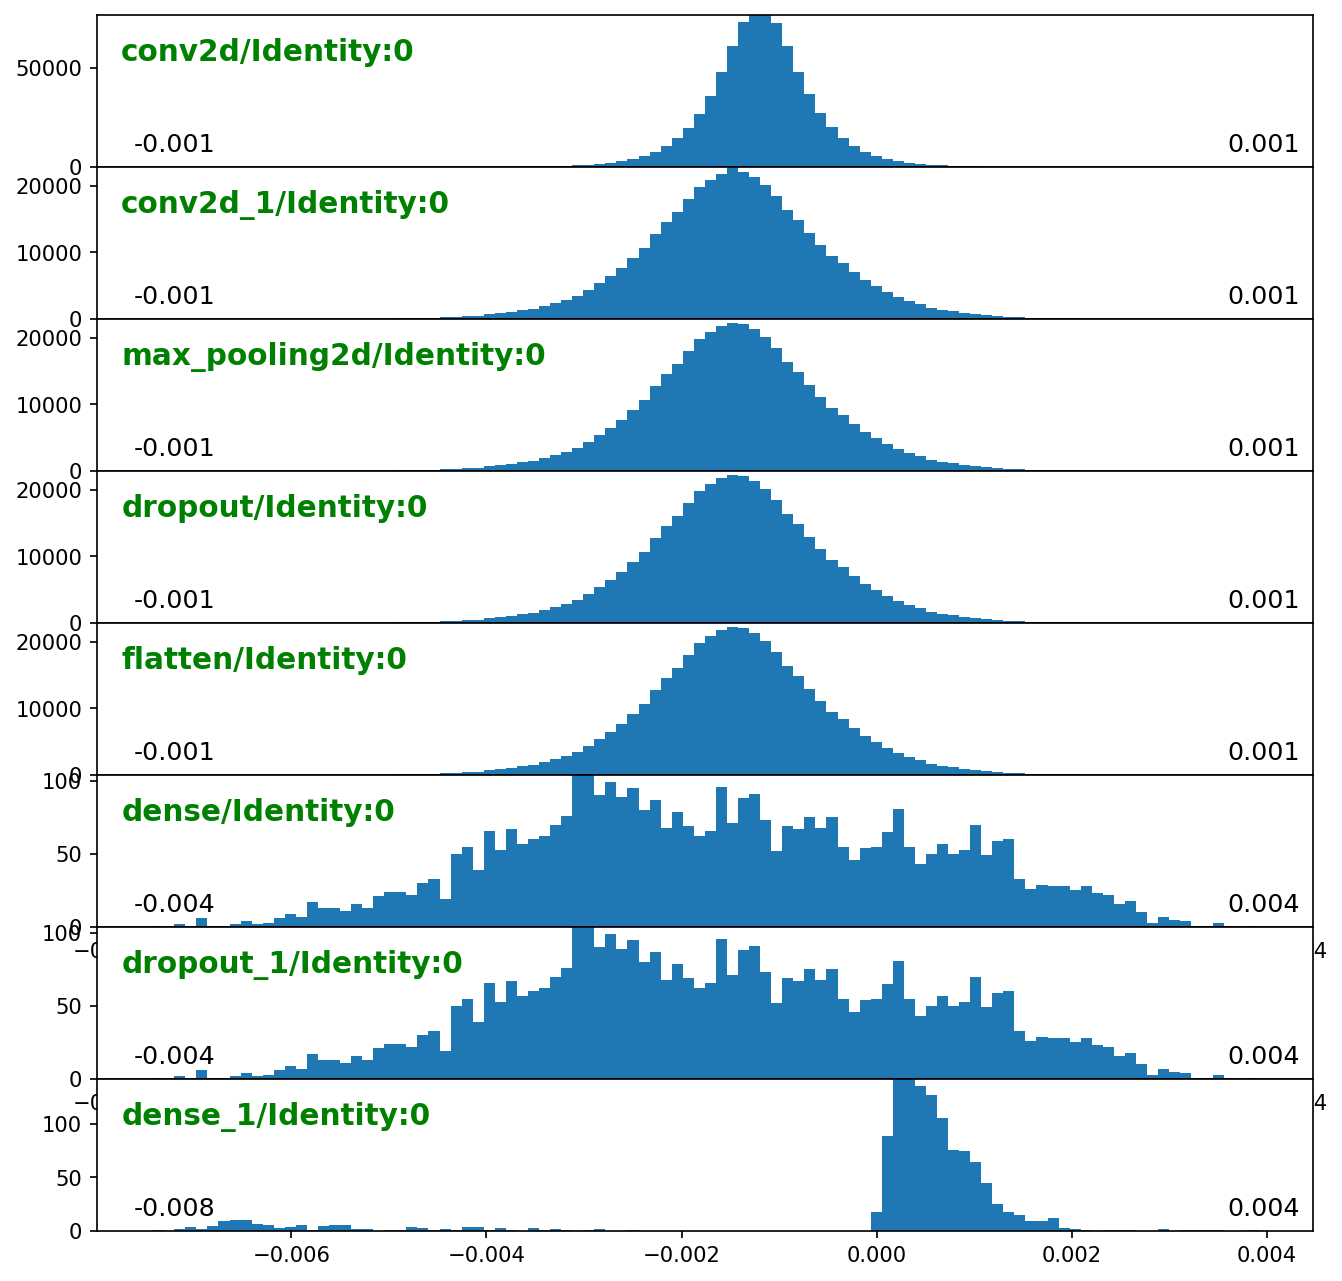

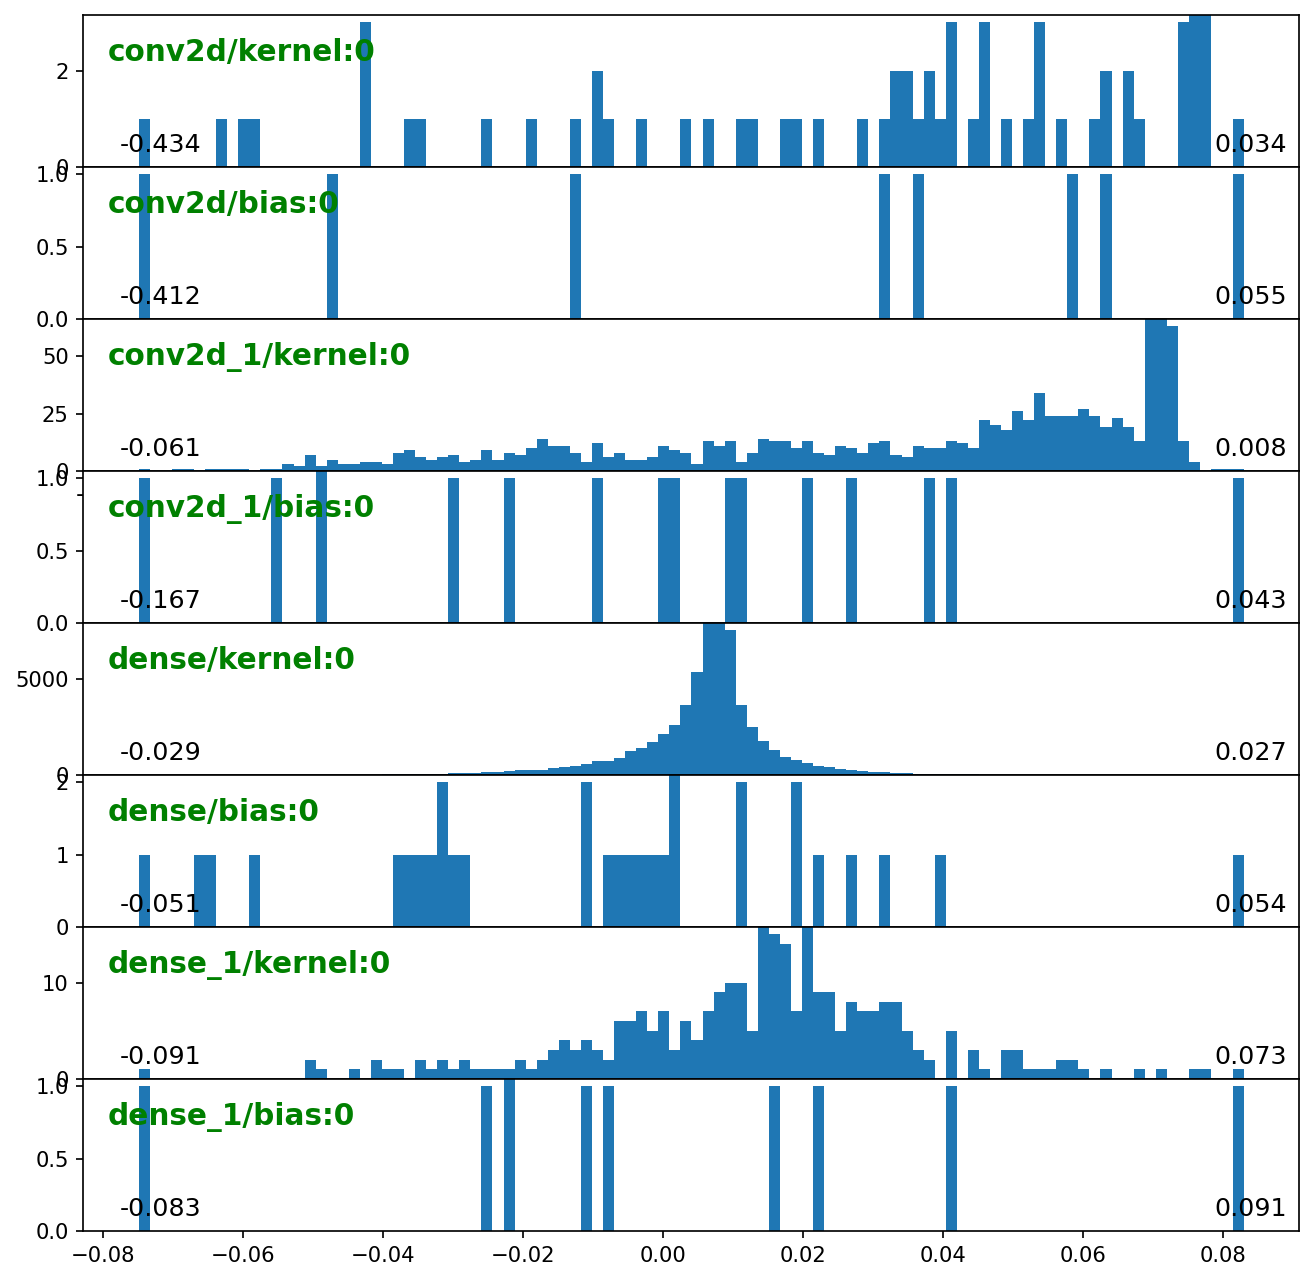



Validating...
Validating set 1...  (Loss, Acc) = (1.401081, 0.656250) 
Validating set 2...  (Loss, Acc) = (1.385388, 0.765625) 
Validating set 3...  (Loss, Acc) = (1.340040, 0.757812) 
Validating set 4...  (Loss, Acc) = (1.342806, 0.734375) 
Validating set 5...  (Loss, Acc) = (1.336356, 0.765625) 
Validating set 6...  (Loss, Acc) = (1.370136, 0.734375) 
Validating set 7...  (Loss, Acc) = (1.367190, 0.679688) 
Validating set 8...  (Loss, Acc) = (1.378983, 0.710938) 
Validating set 9...  (Loss, Acc) = (1.356531, 0.781250) 
Validating set 10... (Loss, Acc) = (1.316610, 0.734375) 
Validating set 11... (Loss, Acc) = (1.292175, 0.781250) 
Validating set 12... (Loss, Acc) = (1.380855, 0.789062) 
Validating set 13... (Loss, Acc) = (1.199720, 0.820312) 
Validating set 14... (Loss, Acc) = (1.354482, 0.796875) 
Validating set 15... (Loss, Acc) = (1.340321, 0.726562) 
Validating set 16... (Loss, Acc) = (1.328282, 0.726562) 
Validating set 17... (Loss, Acc) = (1.358254, 0.742188) 
Validating set 

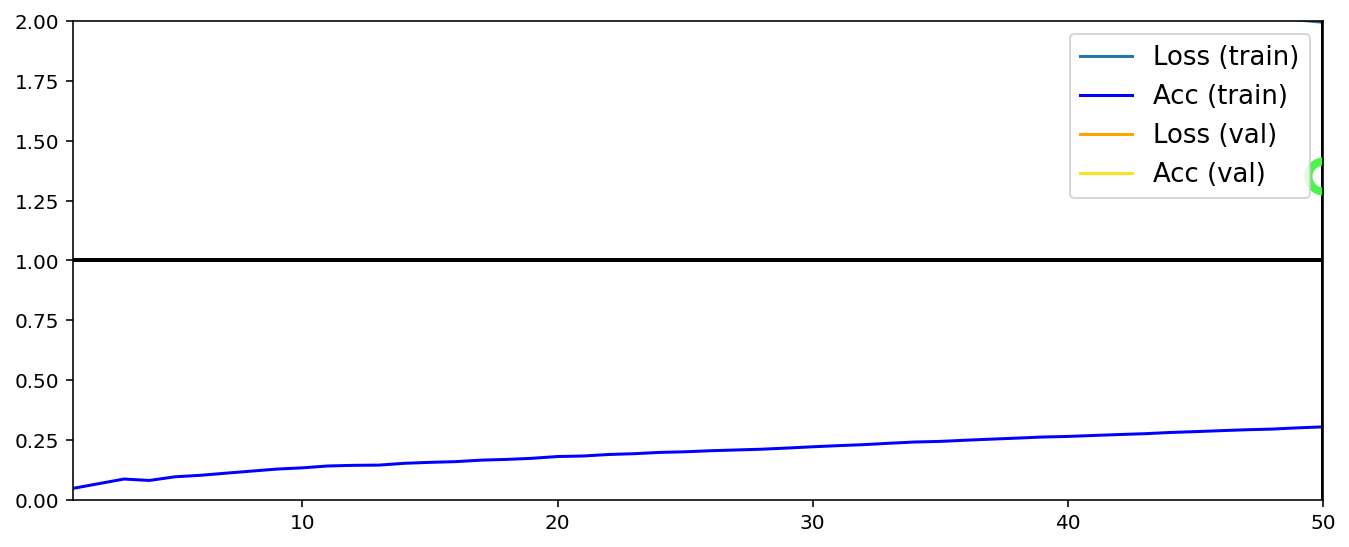

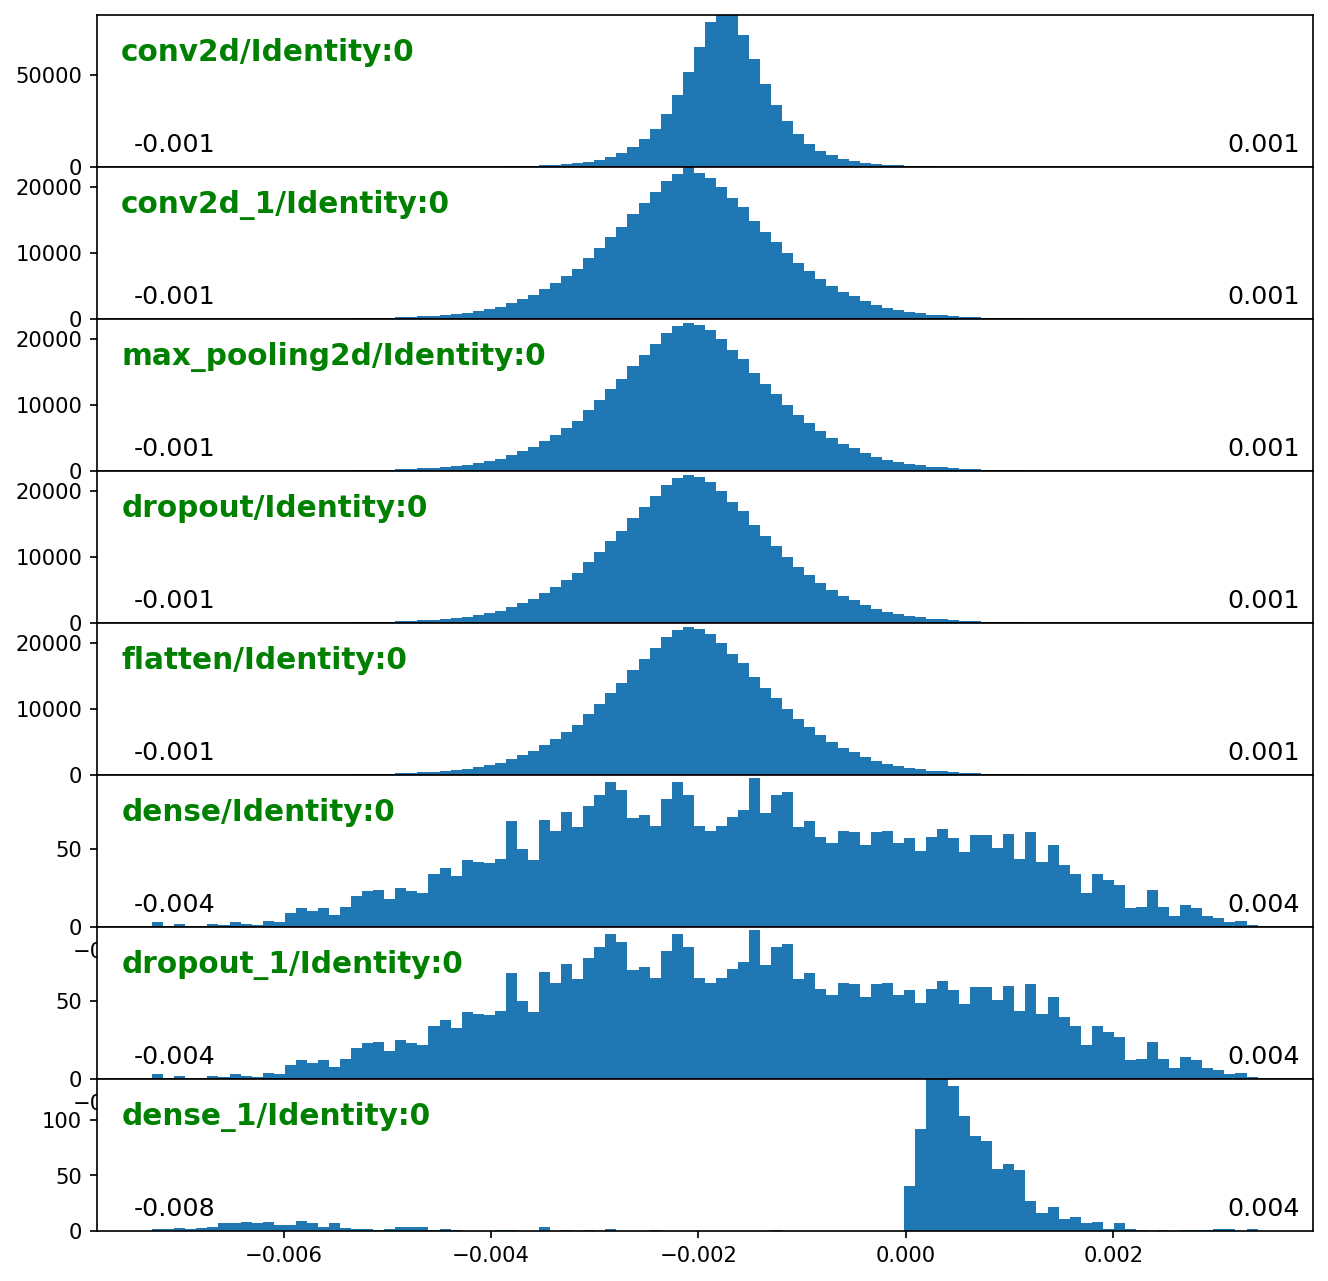

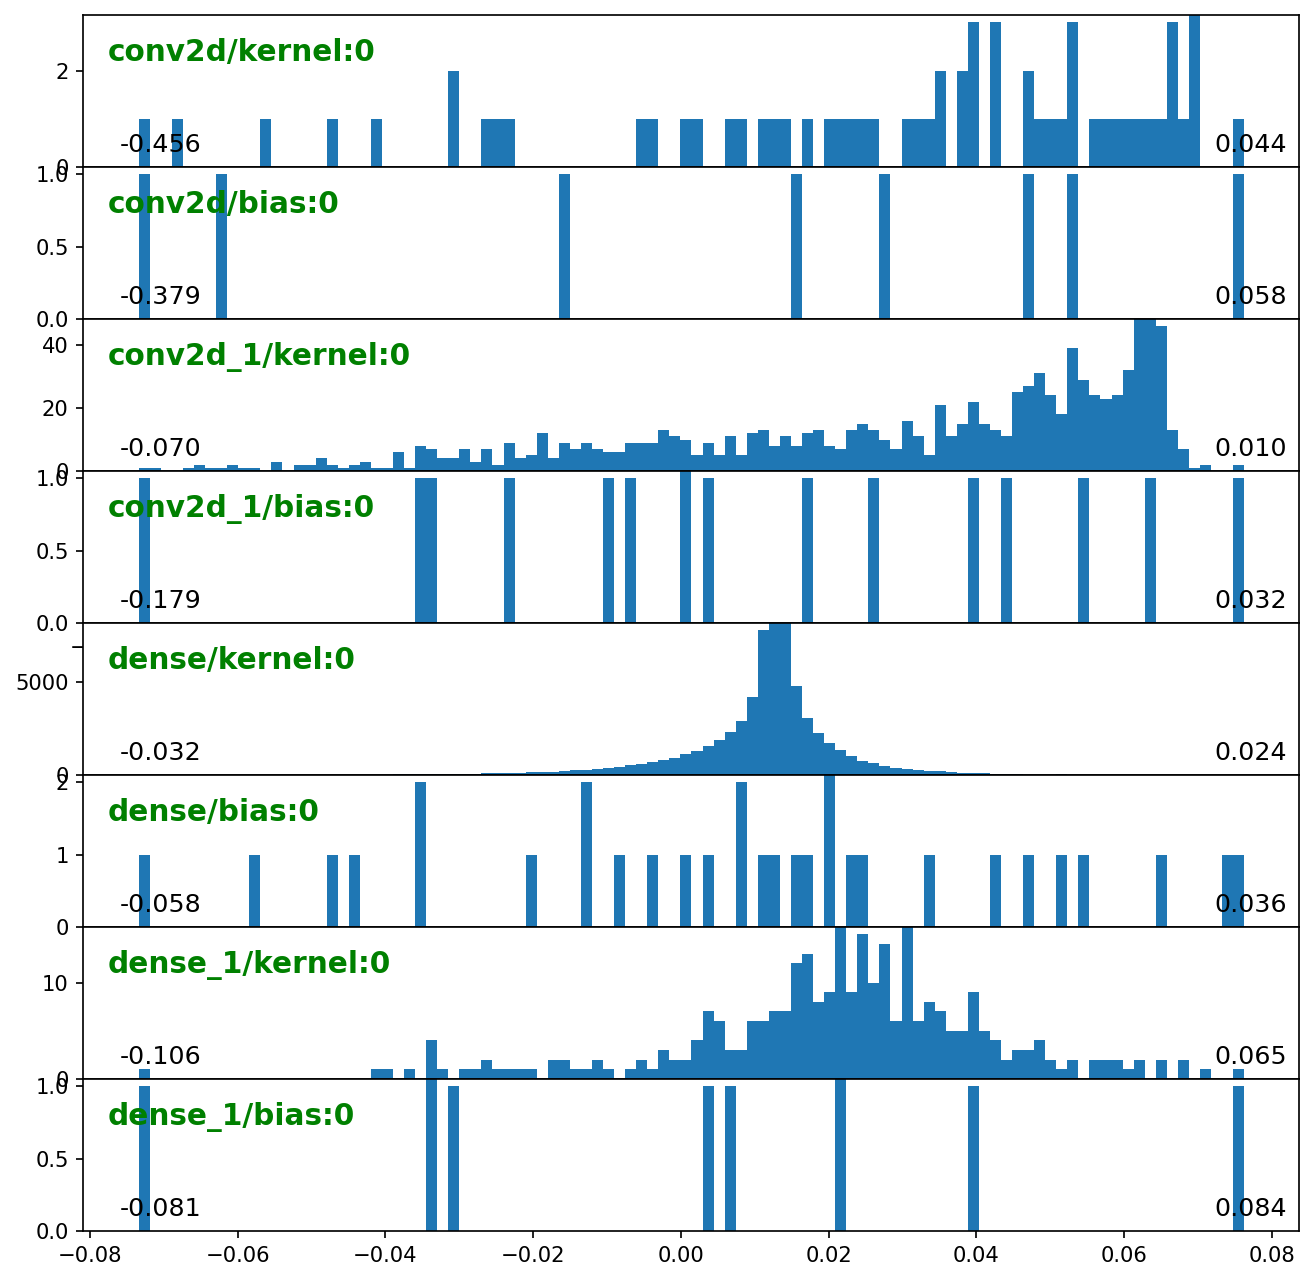

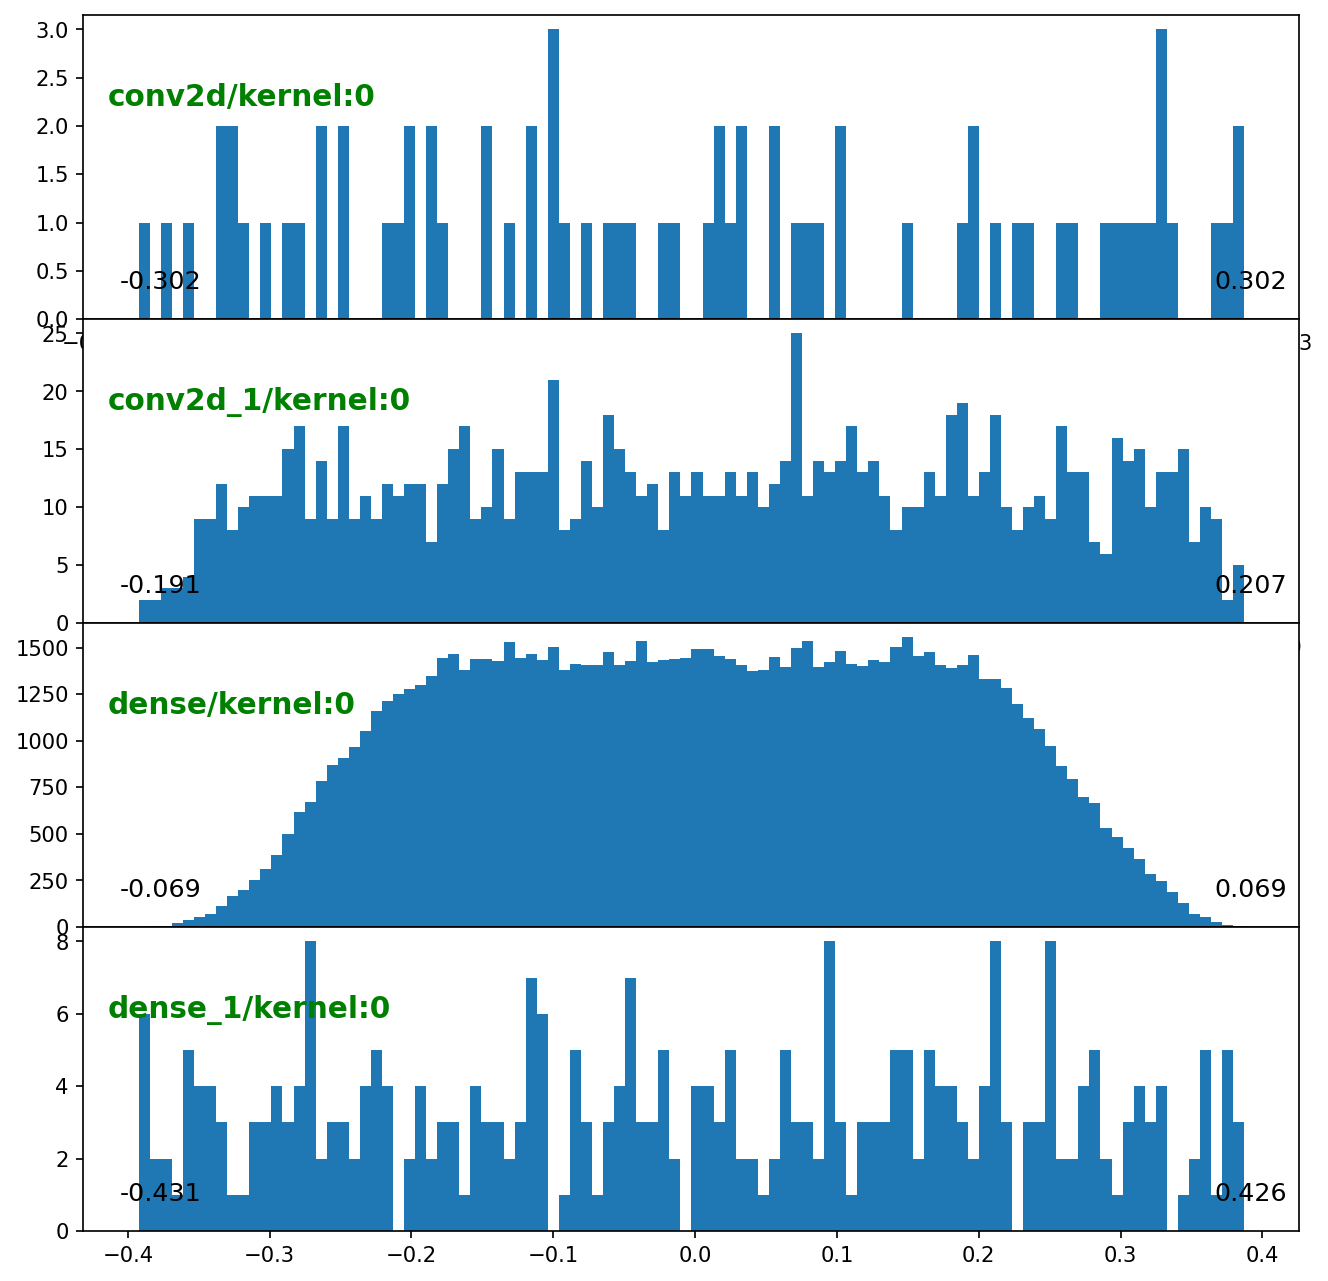

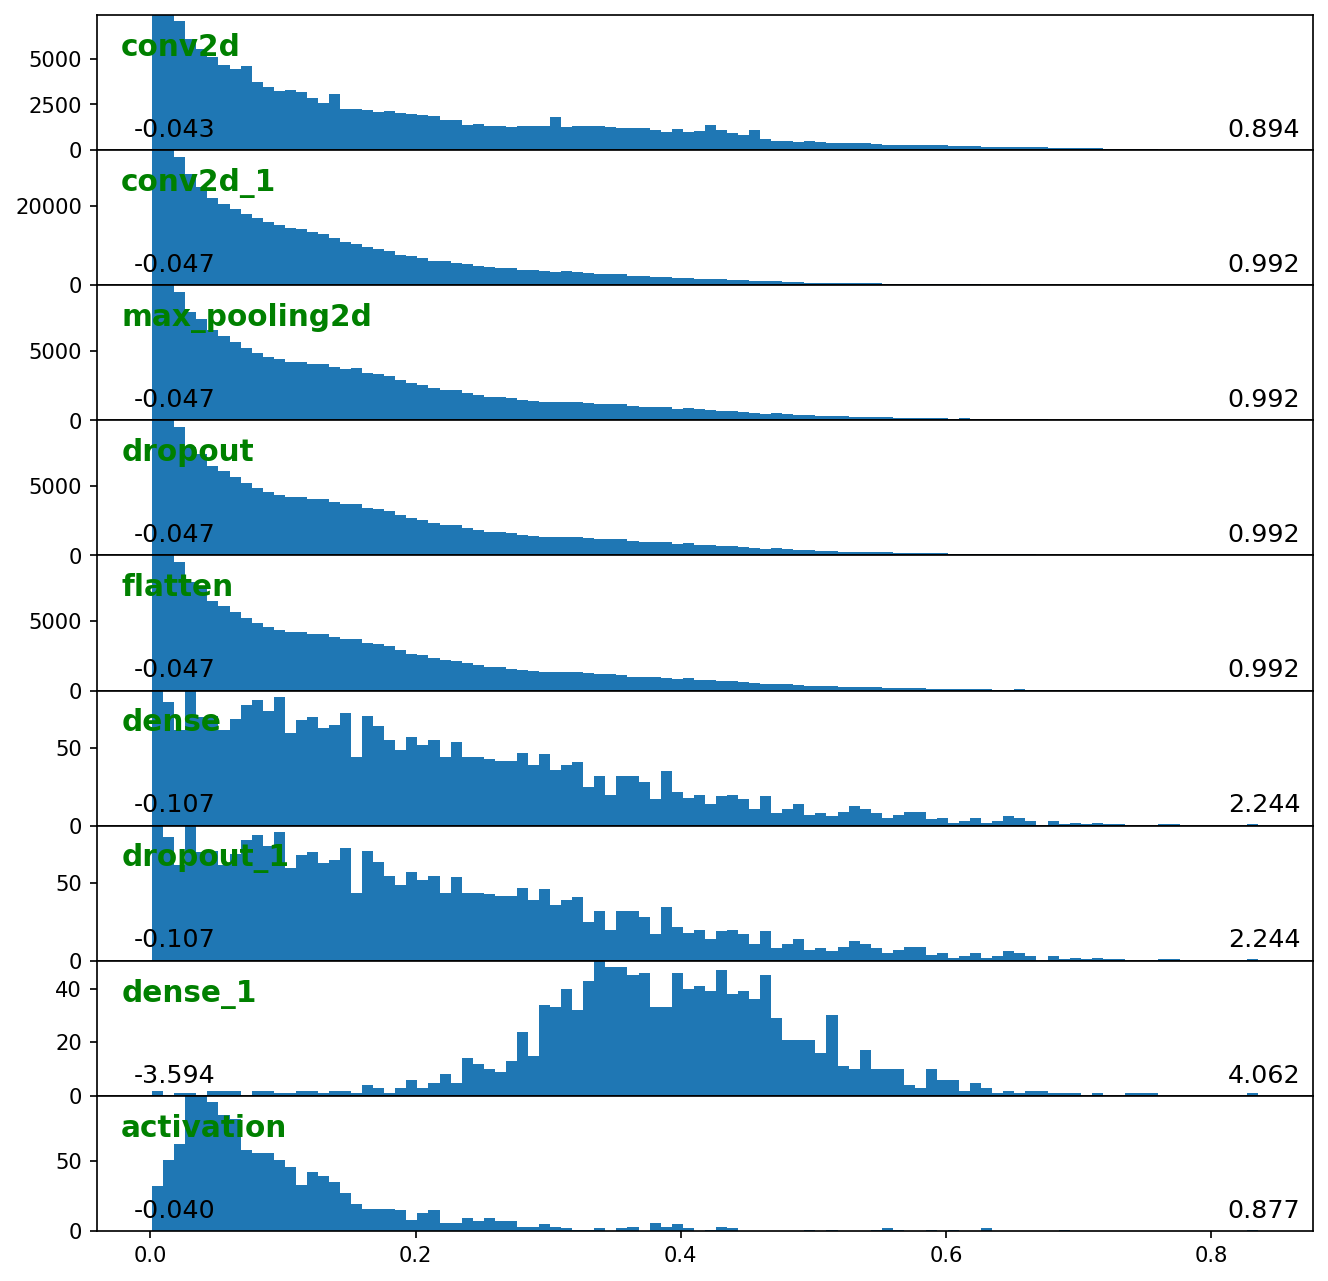


Fitting set 19...  (Loss, Acc) = (1.431350, 0.492188) 
Fitting set 14...  (Loss, Acc) = (1.455080, 0.492188) 
Fitting set 36...  (Loss, Acc) = (1.463616, 0.510417) 
Fitting set 41...  (Loss, Acc) = (1.476896, 0.507812) 
Fitting set 43...  (Loss, Acc) = (1.487504, 0.503125) 
Fitting set 13...  (Loss, Acc) = (1.484260, 0.505208) 
Fitting set 32...  (Loss, Acc) = (1.469364, 0.516741) 
Fitting set 26...  (Loss, Acc) = (1.455949, 0.523438) 
Fitting set 45...  (Loss, Acc) = (1.459831, 0.520833) 
Fitting set 35...  (Loss, Acc) = (1.451632, 0.525000) 
Fitting set 22...  (Loss, Acc) = (1.433930, 0.529830) 
Fitting set 28...  (Loss, Acc) = (1.442758, 0.524740) 
Fitting set 21...  (Loss, Acc) = (1.434699, 0.524038) 
Fitting set 10...  (Loss, Acc) = (1.425216, 0.528460) 
Fitting set 42...  (Loss, Acc) = (1.424216, 0.528125) 
Fitting set 46...  (Loss, Acc) = (1.427788, 0.526367) 
Fitting set 7...   (Loss, Acc) = (1.422017, 0.527574) 
Fitting set 16...  (Loss, Acc) = (1.415167, 0.528212) 
Fitting s

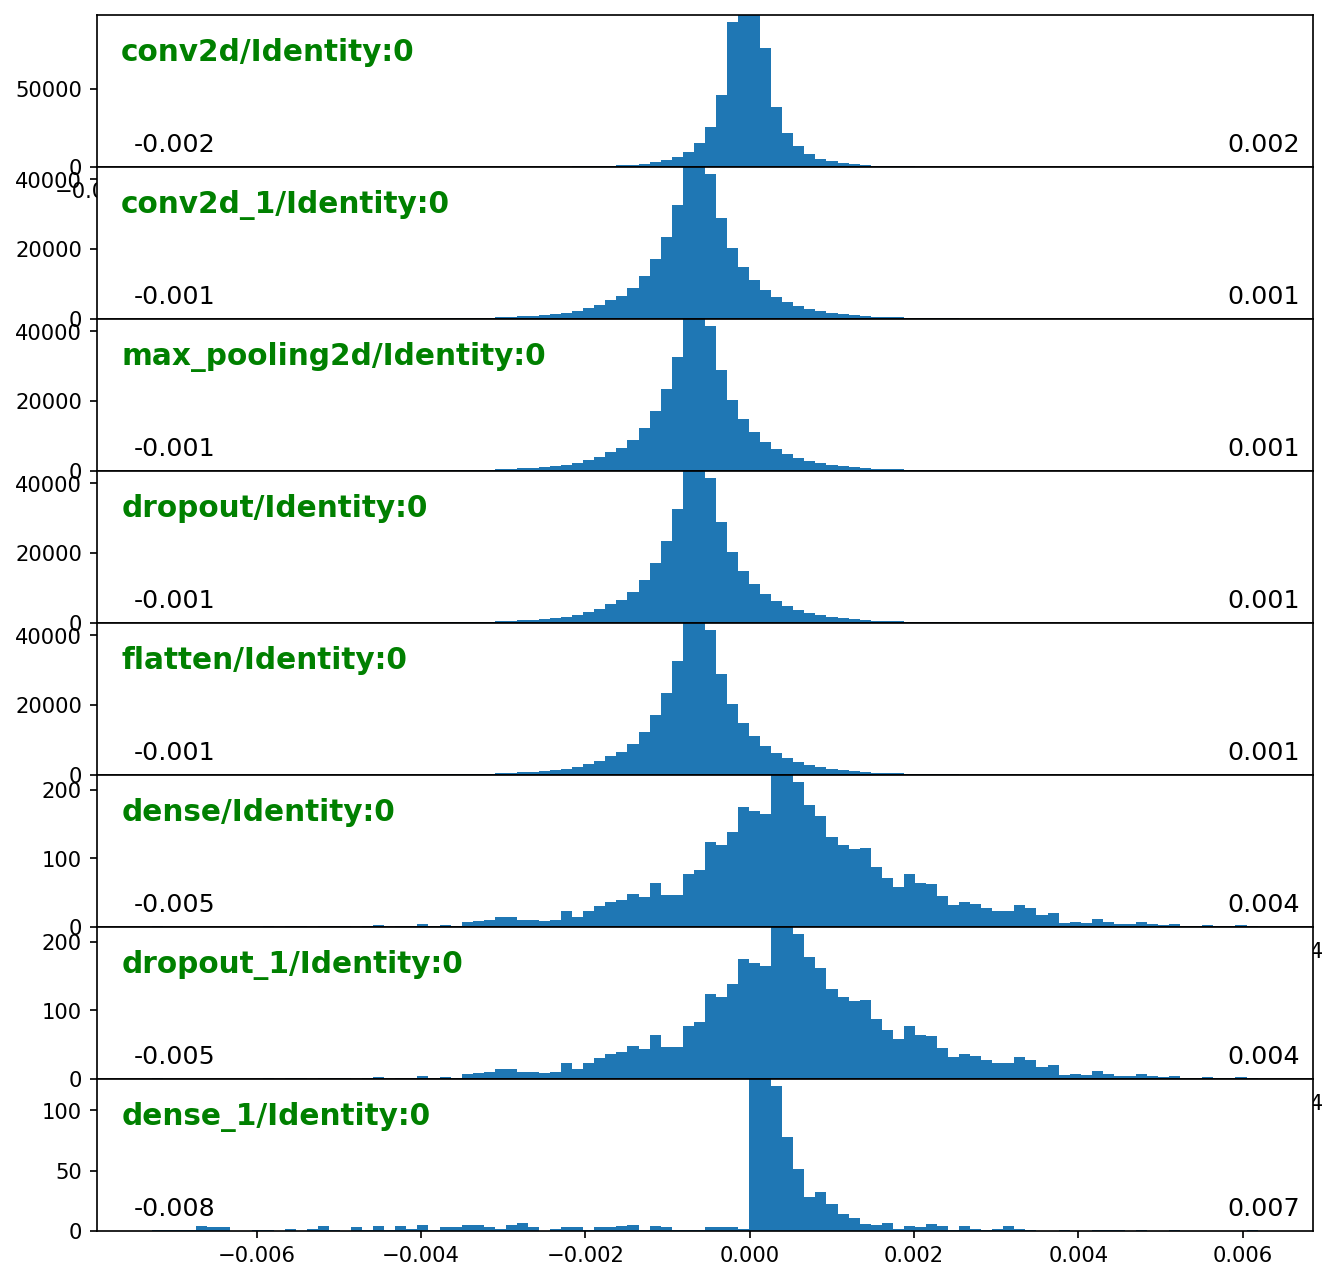

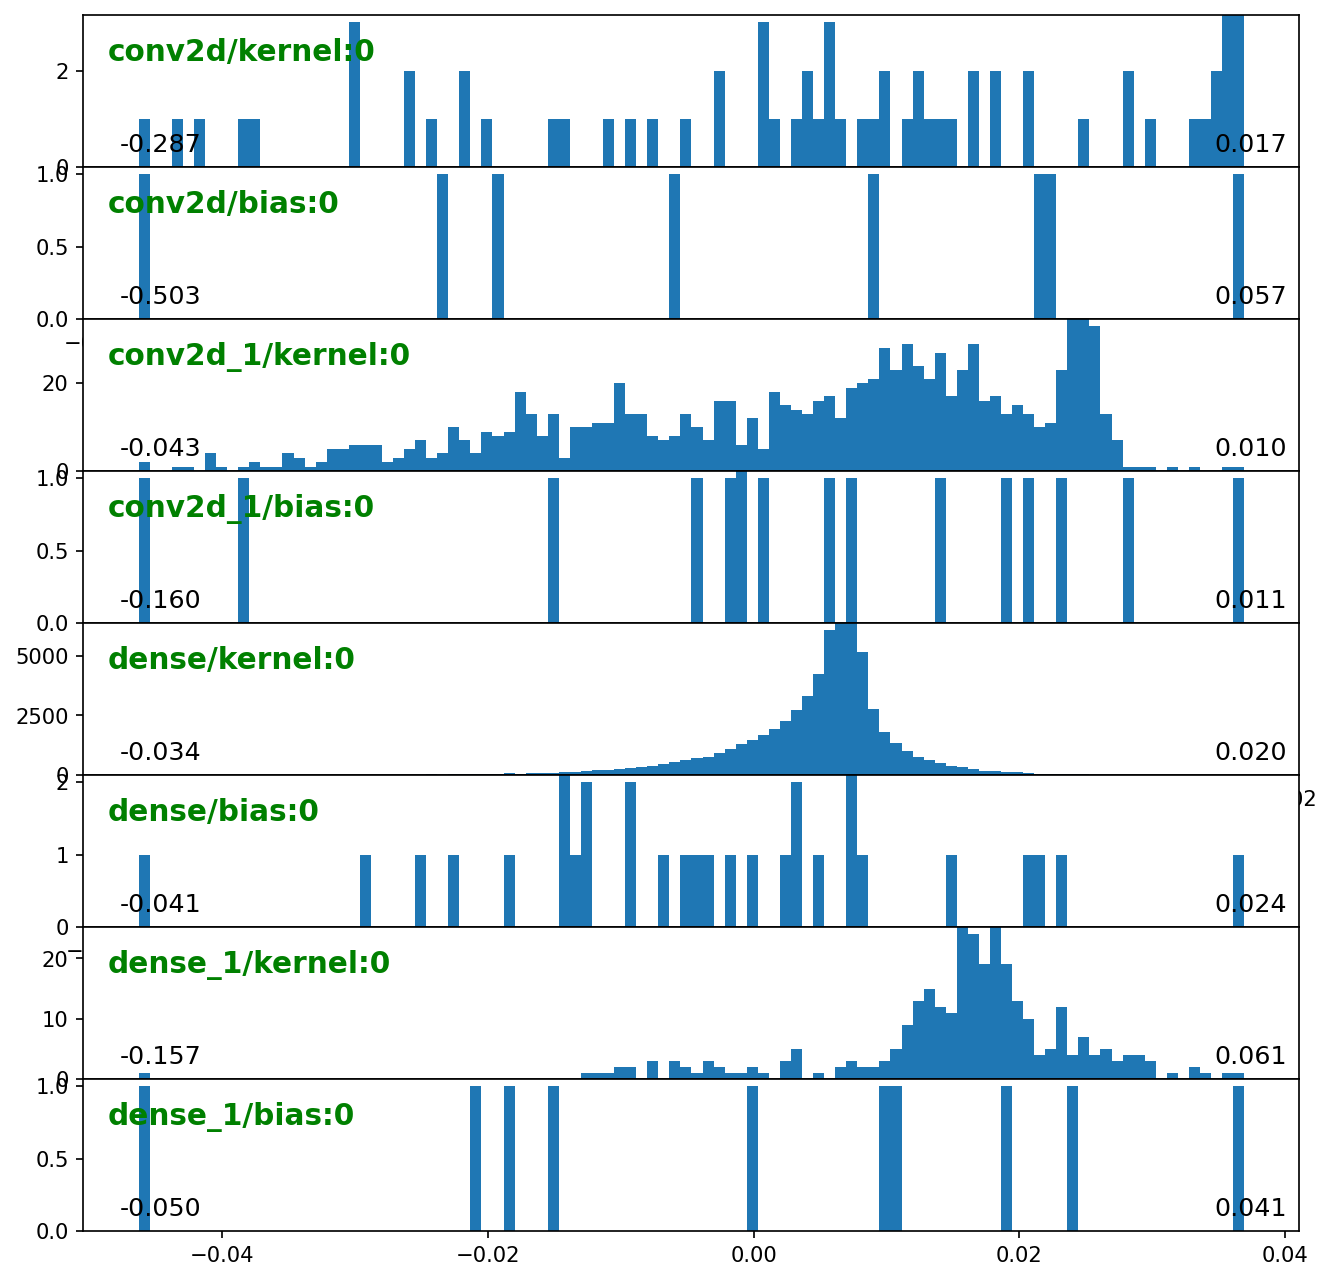



Validating...
Validating set 1...  (Loss, Acc) = (0.684029, 0.828125) 
Validating set 2...  (Loss, Acc) = (0.677565, 0.835938) 
Validating set 3...  (Loss, Acc) = (0.650517, 0.867188) 
Validating set 4...  (Loss, Acc) = (0.682594, 0.859375) 
Validating set 5...  (Loss, Acc) = (0.654127, 0.859375) 
Validating set 6...  (Loss, Acc) = (0.687787, 0.867188) 
Validating set 7...  (Loss, Acc) = (0.639451, 0.867188) 
Validating set 8...  (Loss, Acc) = (0.681368, 0.851562) 
Validating set 9...  (Loss, Acc) = (0.652896, 0.867188) 
Validating set 10... (Loss, Acc) = (0.653767, 0.843750) 
Validating set 11... (Loss, Acc) = (0.555004, 0.921875) 
Validating set 12... (Loss, Acc) = (0.670832, 0.882812) 
Validating set 13... (Loss, Acc) = (0.539183, 0.882812) 
Validating set 14... (Loss, Acc) = (0.627128, 0.898438) 
Validating set 15... (Loss, Acc) = (0.724787, 0.828125) 
Validating set 16... (Loss, Acc) = (0.696036, 0.820312) 
Validating set 17... (Loss, Acc) = (0.643124, 0.843750) 
Validating set 

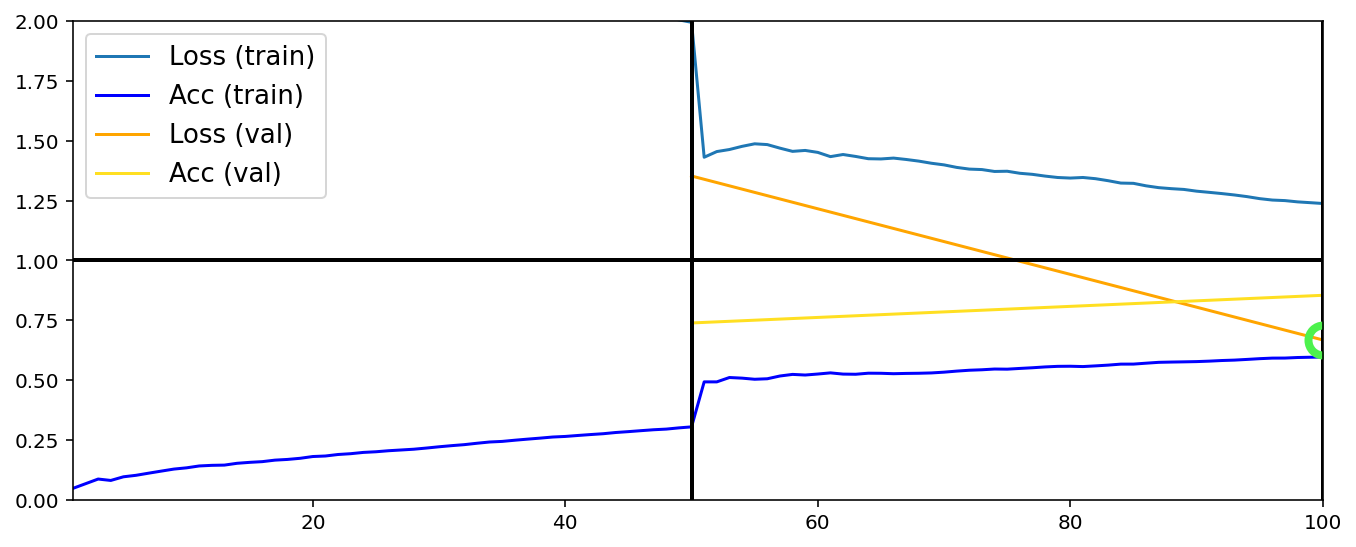

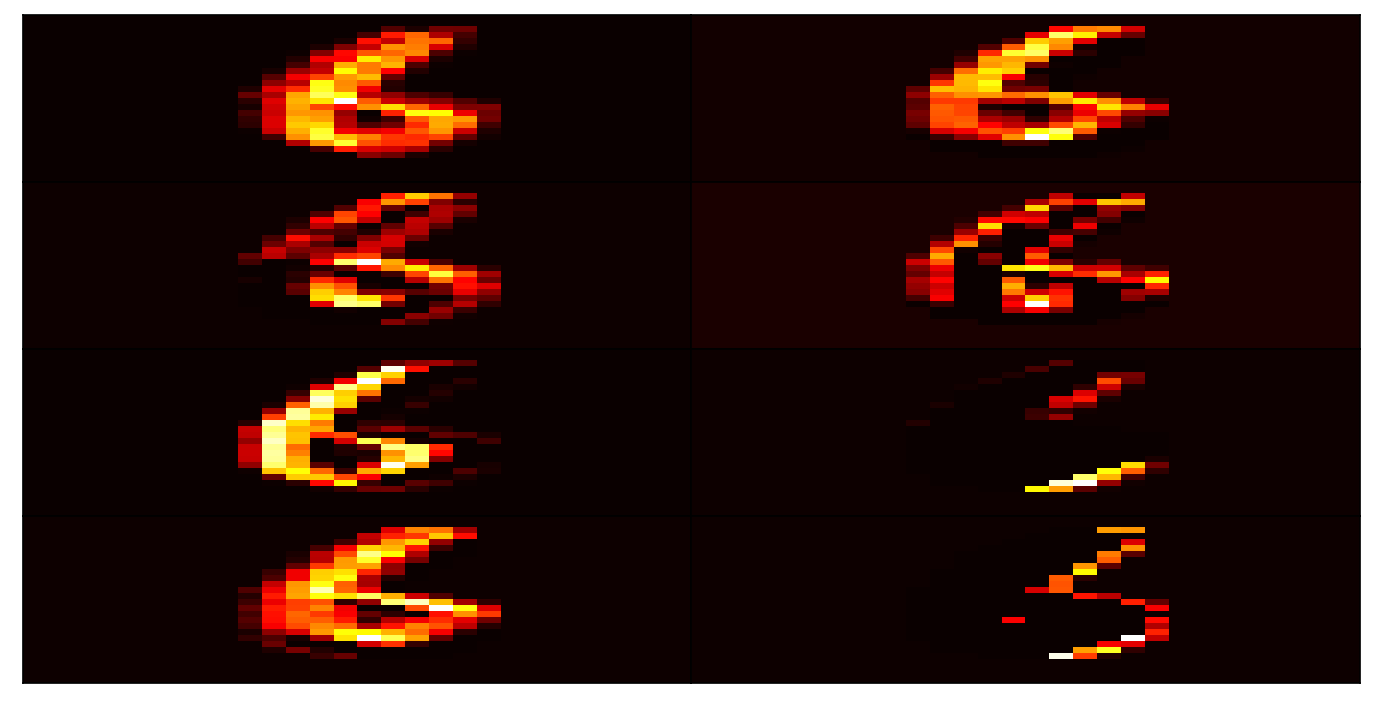

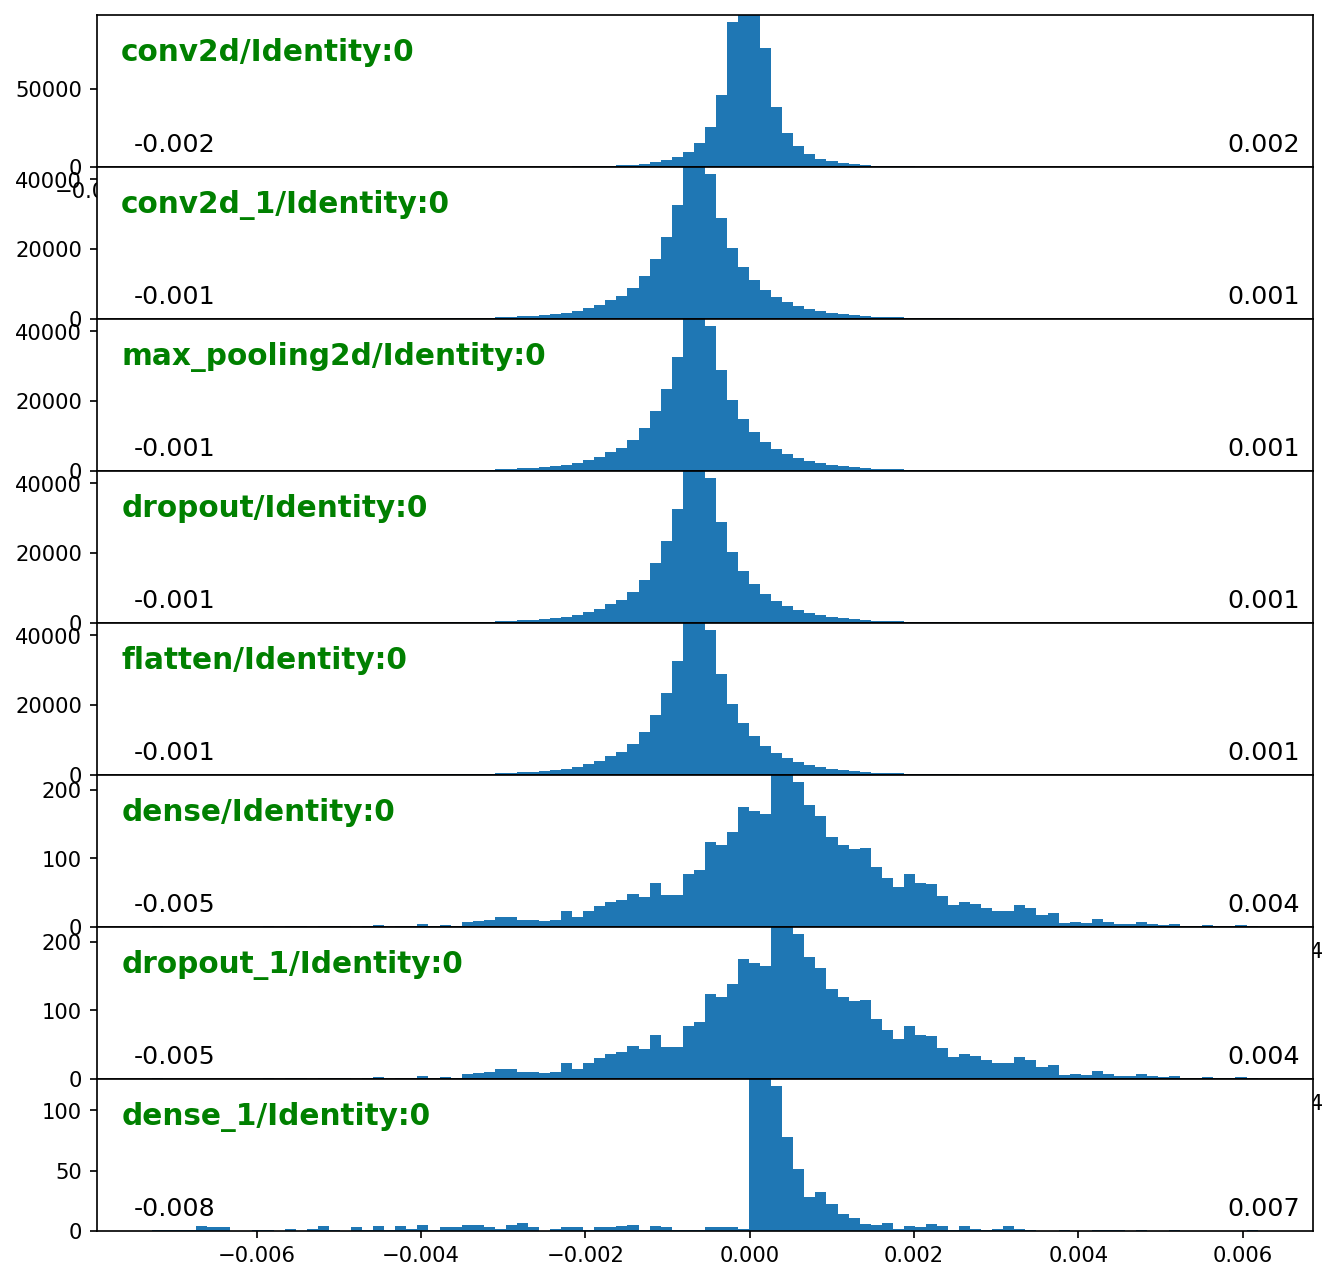

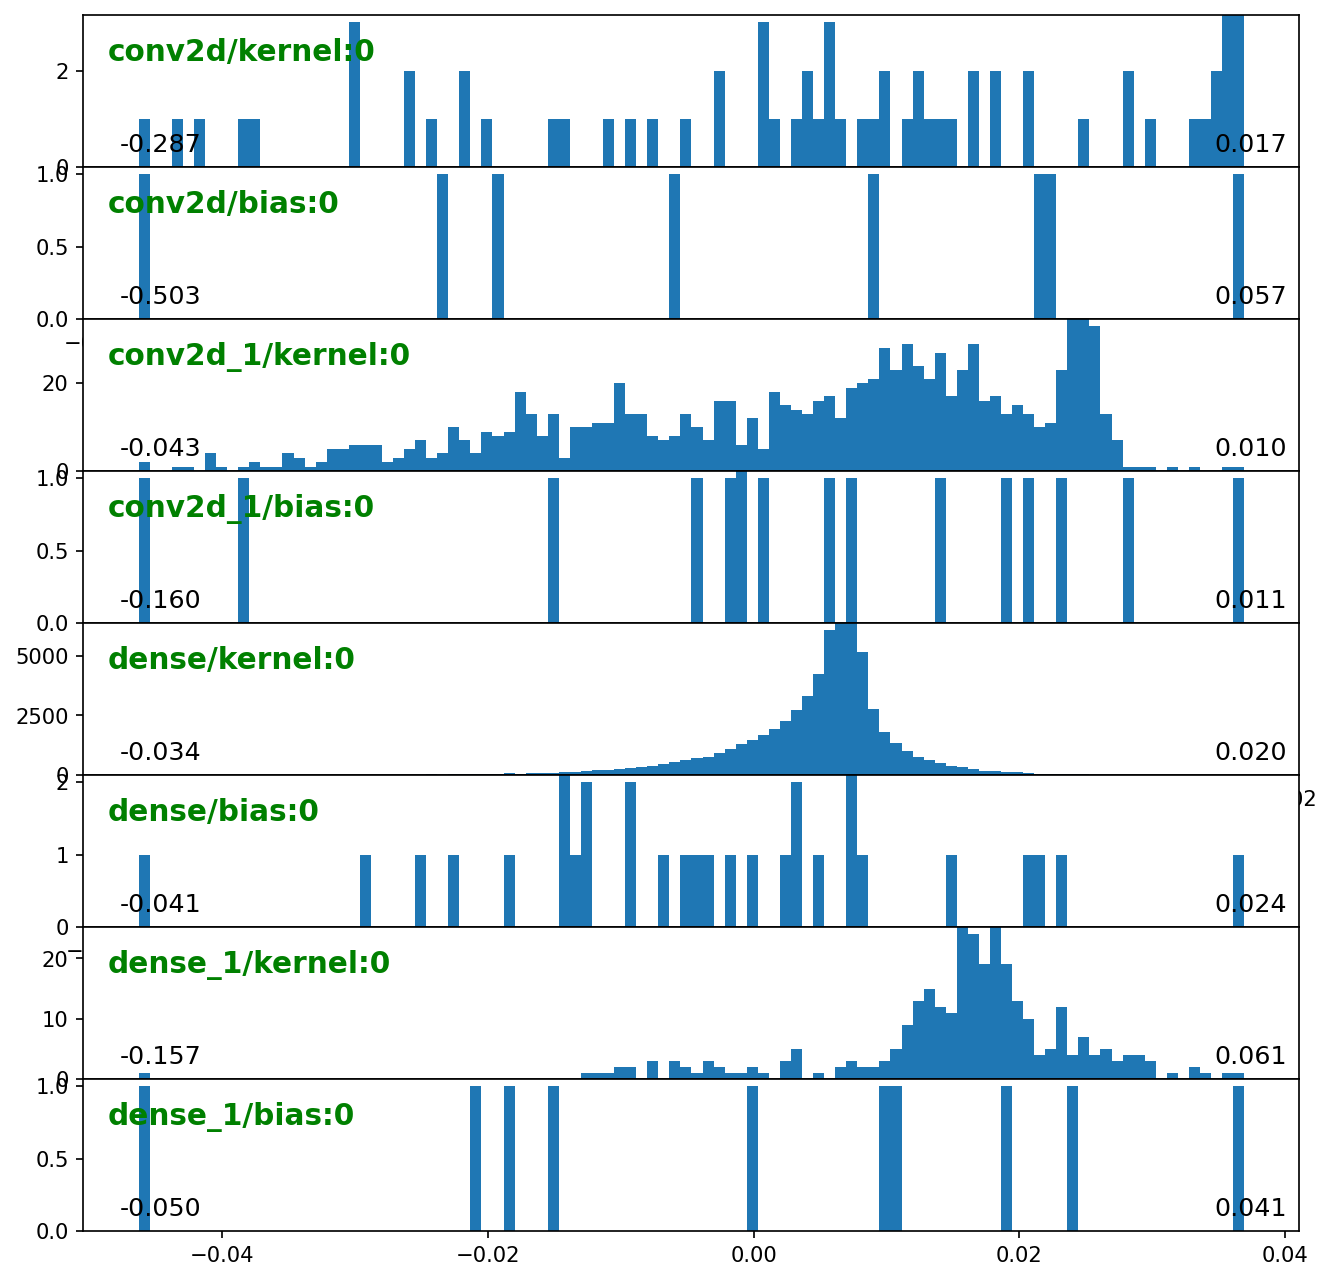

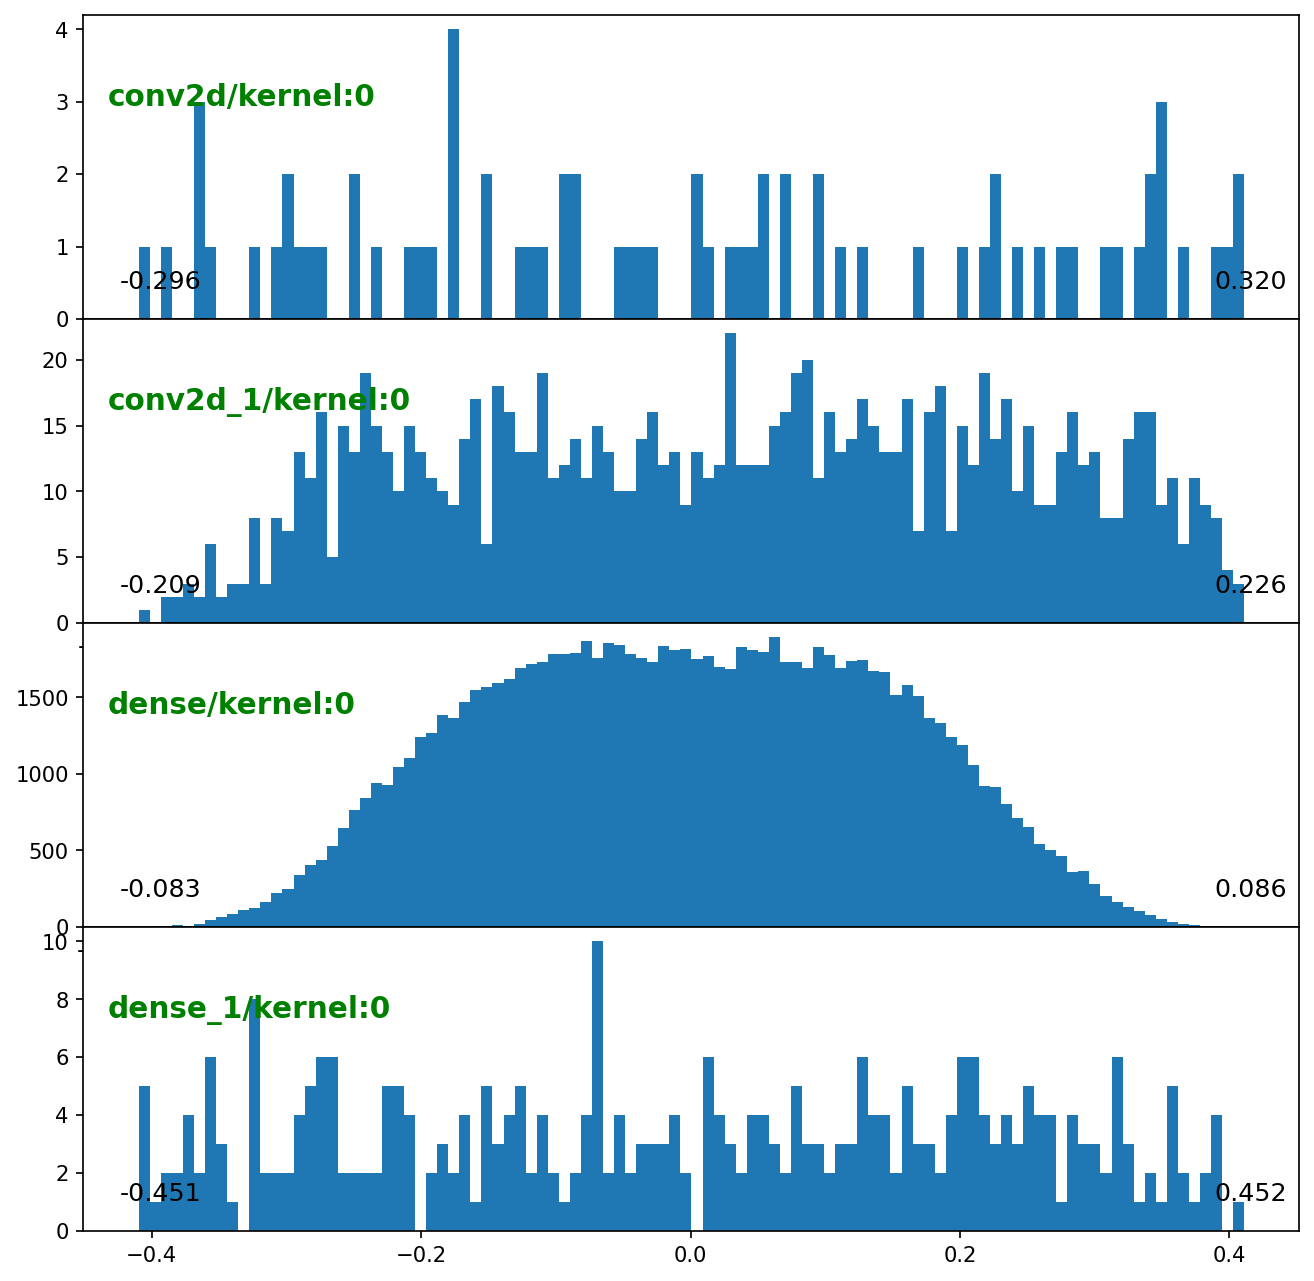

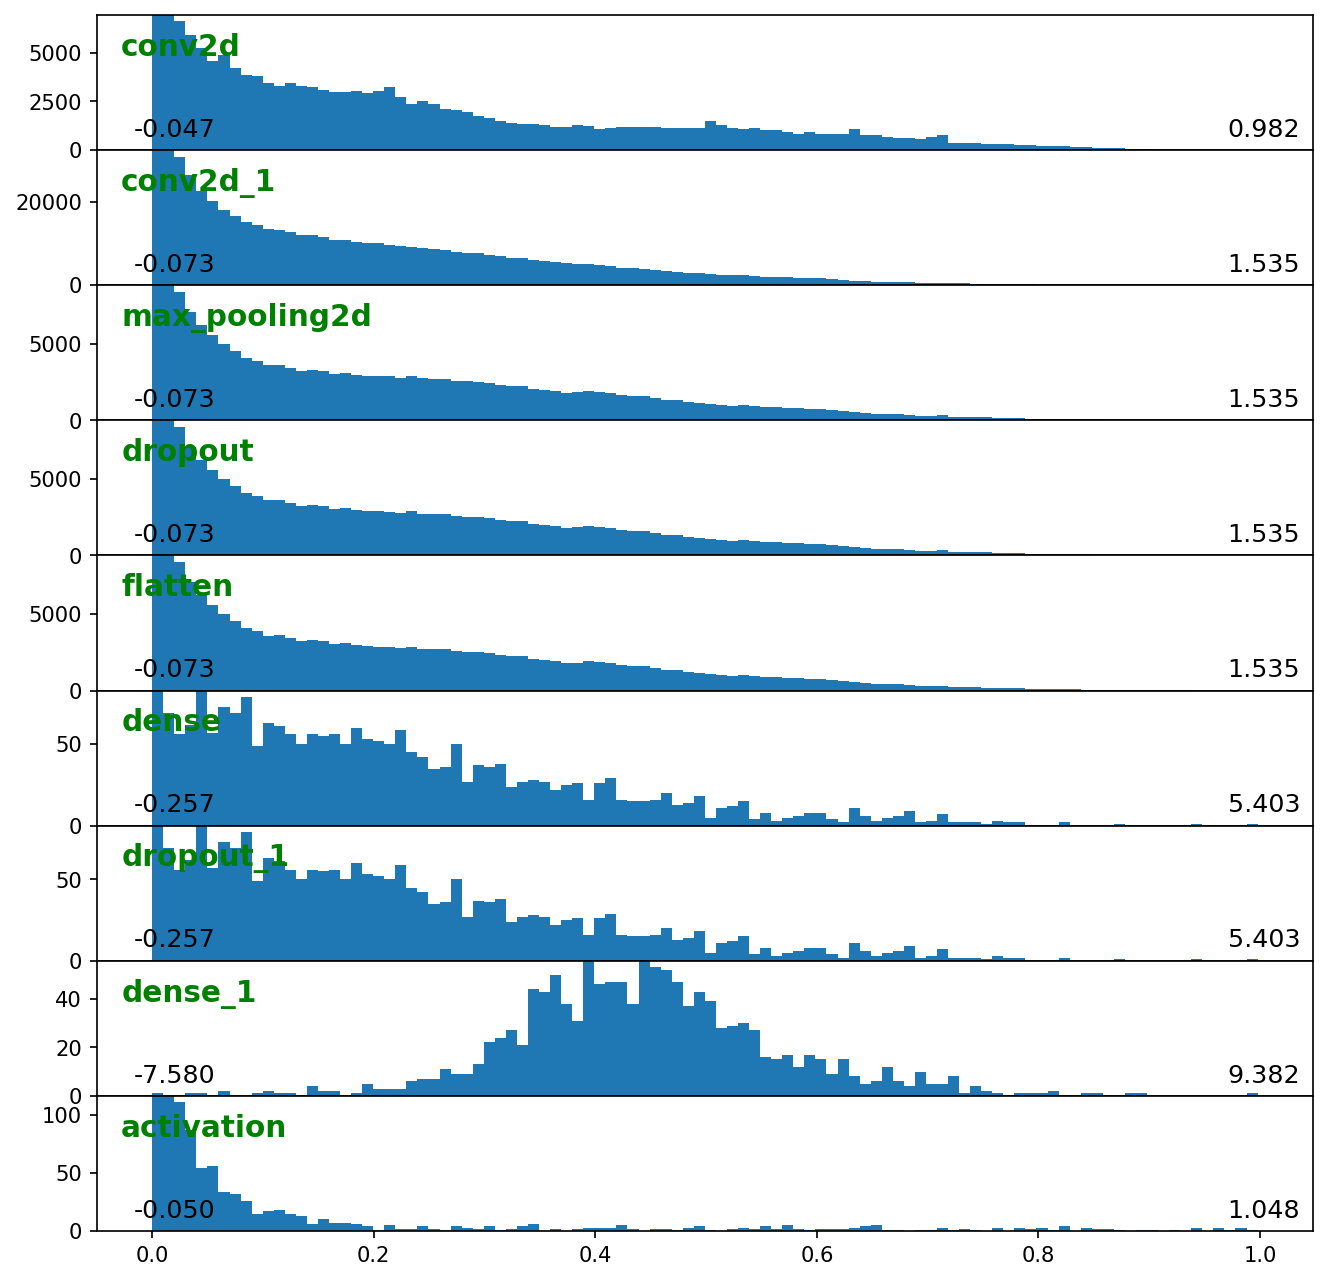


Fitting set 2...   (Loss, Acc) = (0.714438, 0.671875) 
Fitting set 10...  (Loss, Acc) = (0.907476, 0.683594) 
Fitting set 6...   (Loss, Acc) = (0.917716, 0.695312) 
Fitting set 38...  (Loss, Acc) = (0.953135, 0.681641) 
Fitting set 20...  (Loss, Acc) = (0.961120, 0.684375) 
Fitting set 22...  (Loss, Acc) = (0.927500, 0.705729) 
Fitting set 24...  (Loss, Acc) = (0.921787, 0.712054) 
Fitting set 13...  (Loss, Acc) = (0.944124, 0.700195) 
Fitting set 35...  (Loss, Acc) = (0.964167, 0.692708) 
Fitting set 46...  (Loss, Acc) = (0.978568, 0.685156) 
Fitting set 16...  (Loss, Acc) = (0.984900, 0.683949) 
Fitting set 39...  (Loss, Acc) = (0.974800, 0.686849) 
Fitting set 5...   (Loss, Acc) = (0.976200, 0.688702) 
Fitting set 27...  (Loss, Acc) = (0.972066, 0.688058) 
Fitting set 31...  (Loss, Acc) = (0.969184, 0.688021) 
Fitting set 18...  (Loss, Acc) = (0.975040, 0.685547) 
Fitting set 25...  (Loss, Acc) = (0.981926, 0.683824) 
Fitting set 19...  (Loss, Acc) = (0.984384, 0.684462) 
Fitting s

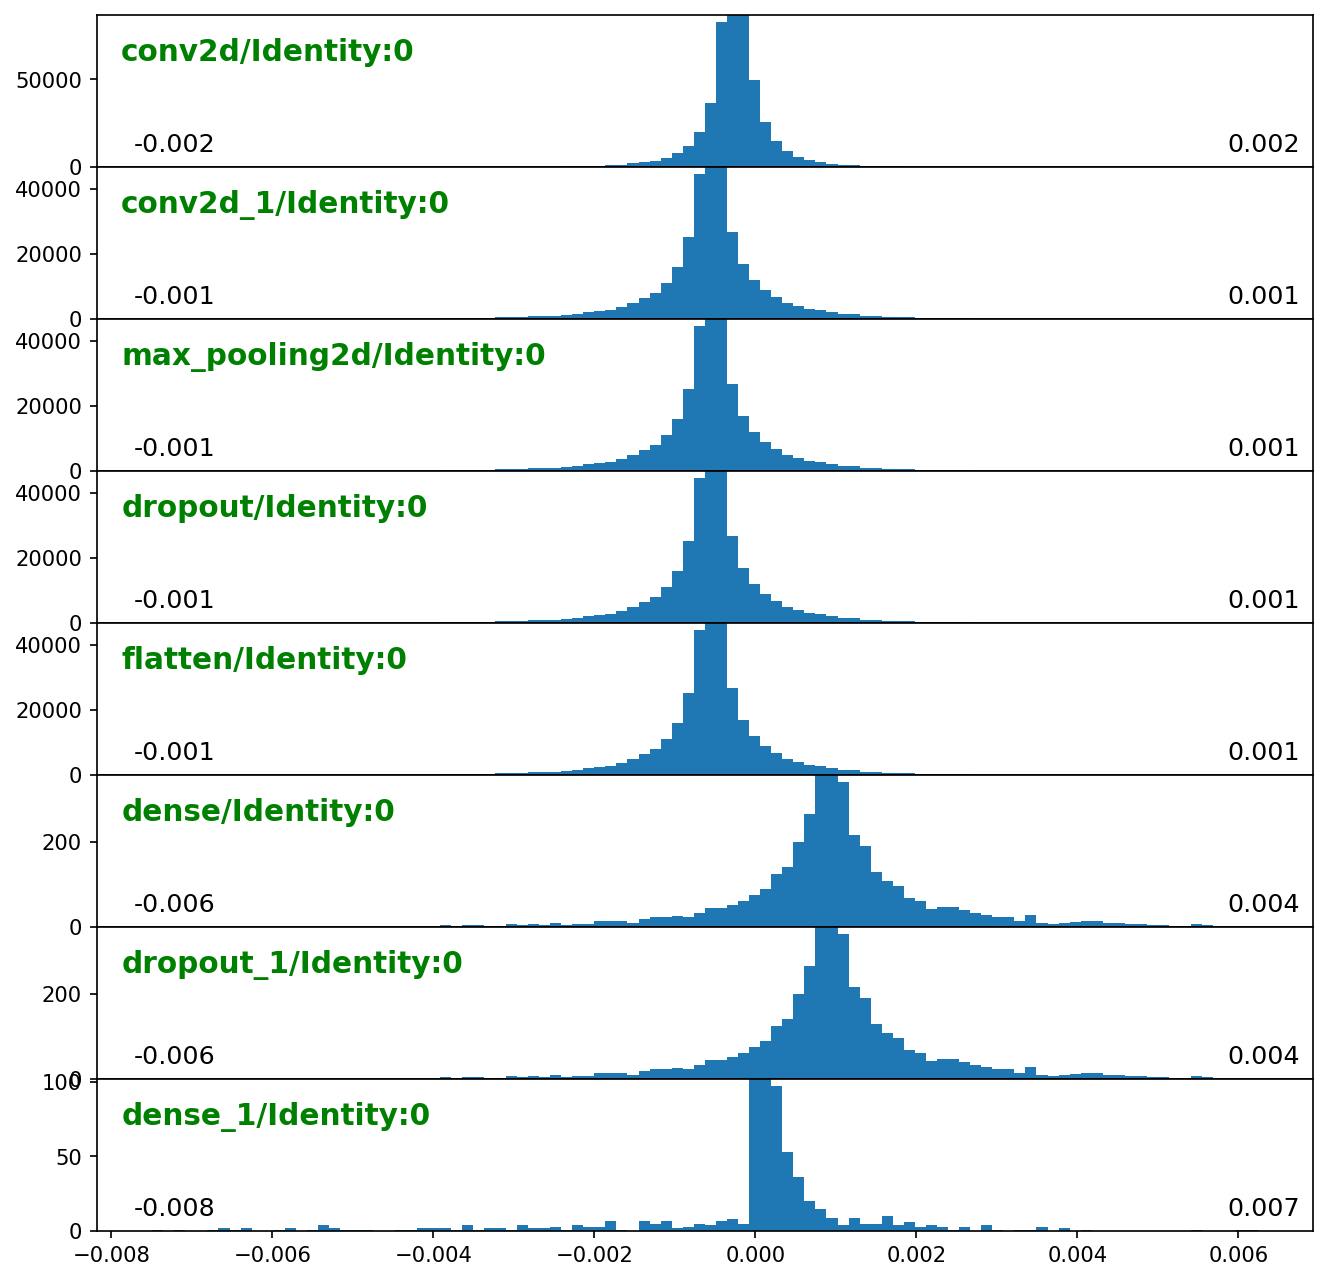

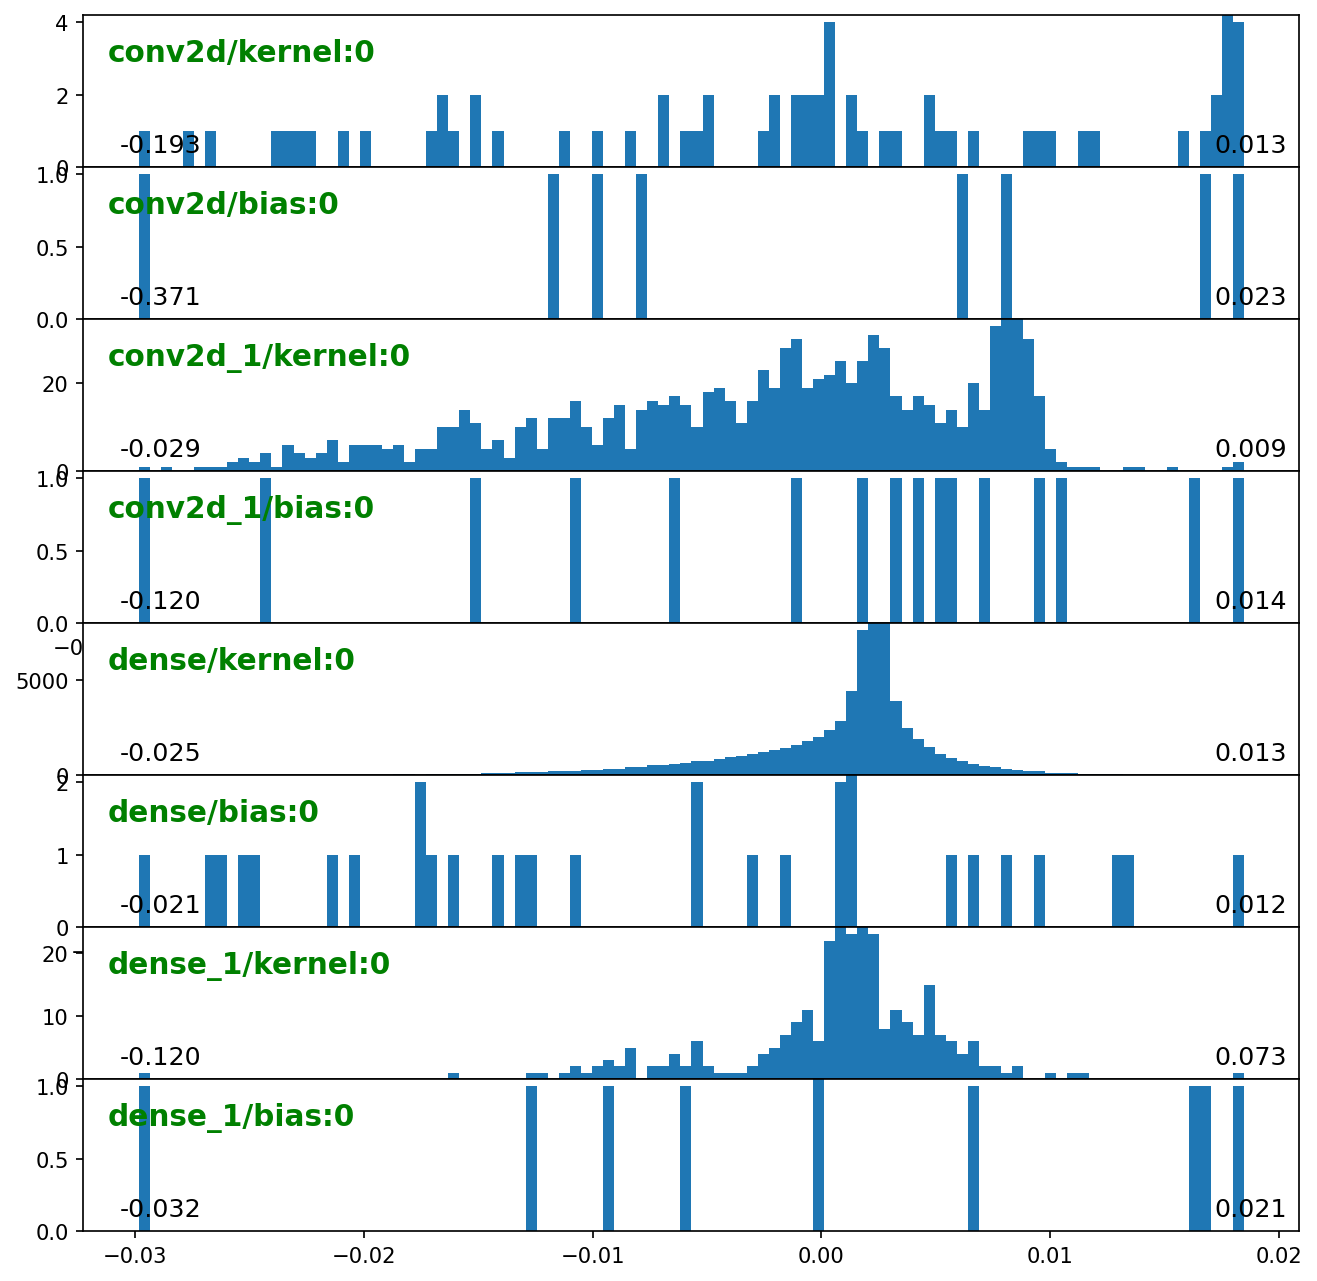



Validating...
Validating set 1...  (Loss, Acc) = (0.490918, 0.890625) 
Validating set 2...  (Loss, Acc) = (0.485152, 0.921875) 
Validating set 3...  (Loss, Acc) = (0.494724, 0.875000) 
Validating set 4...  (Loss, Acc) = (0.508180, 0.875000) 
Validating set 5...  (Loss, Acc) = (0.511666, 0.890625) 
Validating set 6...  (Loss, Acc) = (0.504422, 0.882812) 
Validating set 7...  (Loss, Acc) = (0.453368, 0.882812) 
Validating set 8...  (Loss, Acc) = (0.519443, 0.875000) 
Validating set 9...  (Loss, Acc) = (0.477845, 0.921875) 
Validating set 10... (Loss, Acc) = (0.494369, 0.875000) 
Validating set 11... (Loss, Acc) = (0.383610, 0.914062) 
Validating set 12... (Loss, Acc) = (0.500754, 0.875000) 
Validating set 13... (Loss, Acc) = (0.381182, 0.890625) 
Validating set 14... (Loss, Acc) = (0.475606, 0.882812) 
Validating set 15... (Loss, Acc) = (0.584552, 0.867188) 
Validating set 16... (Loss, Acc) = (0.541129, 0.867188) 
Validating set 17... (Loss, Acc) = (0.444447, 0.898438) 
Validating set 

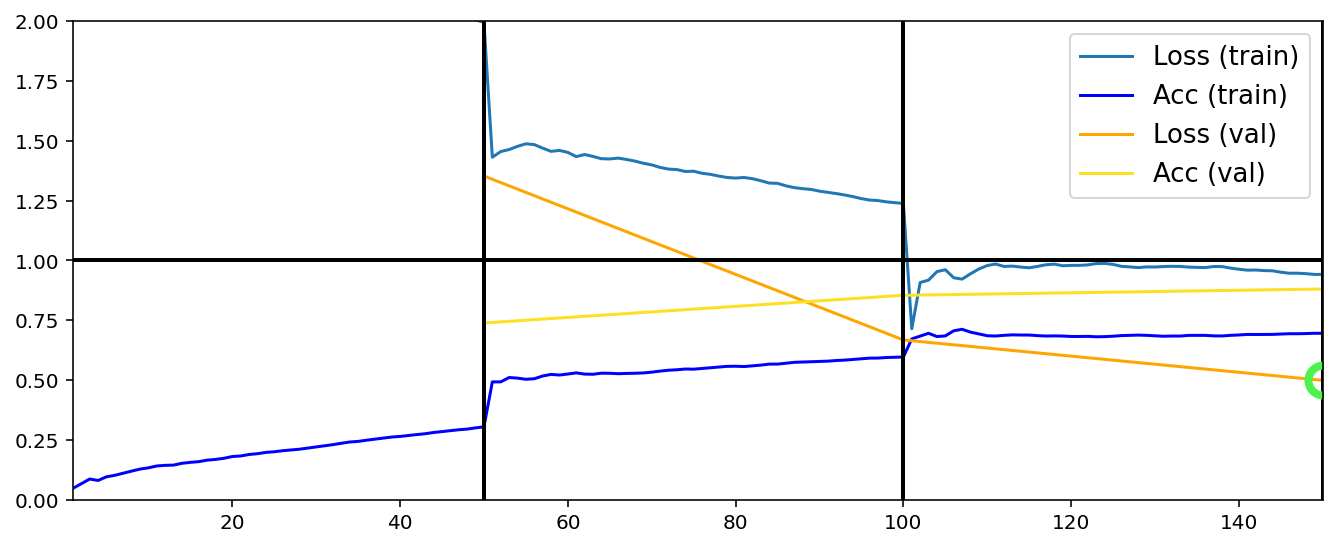

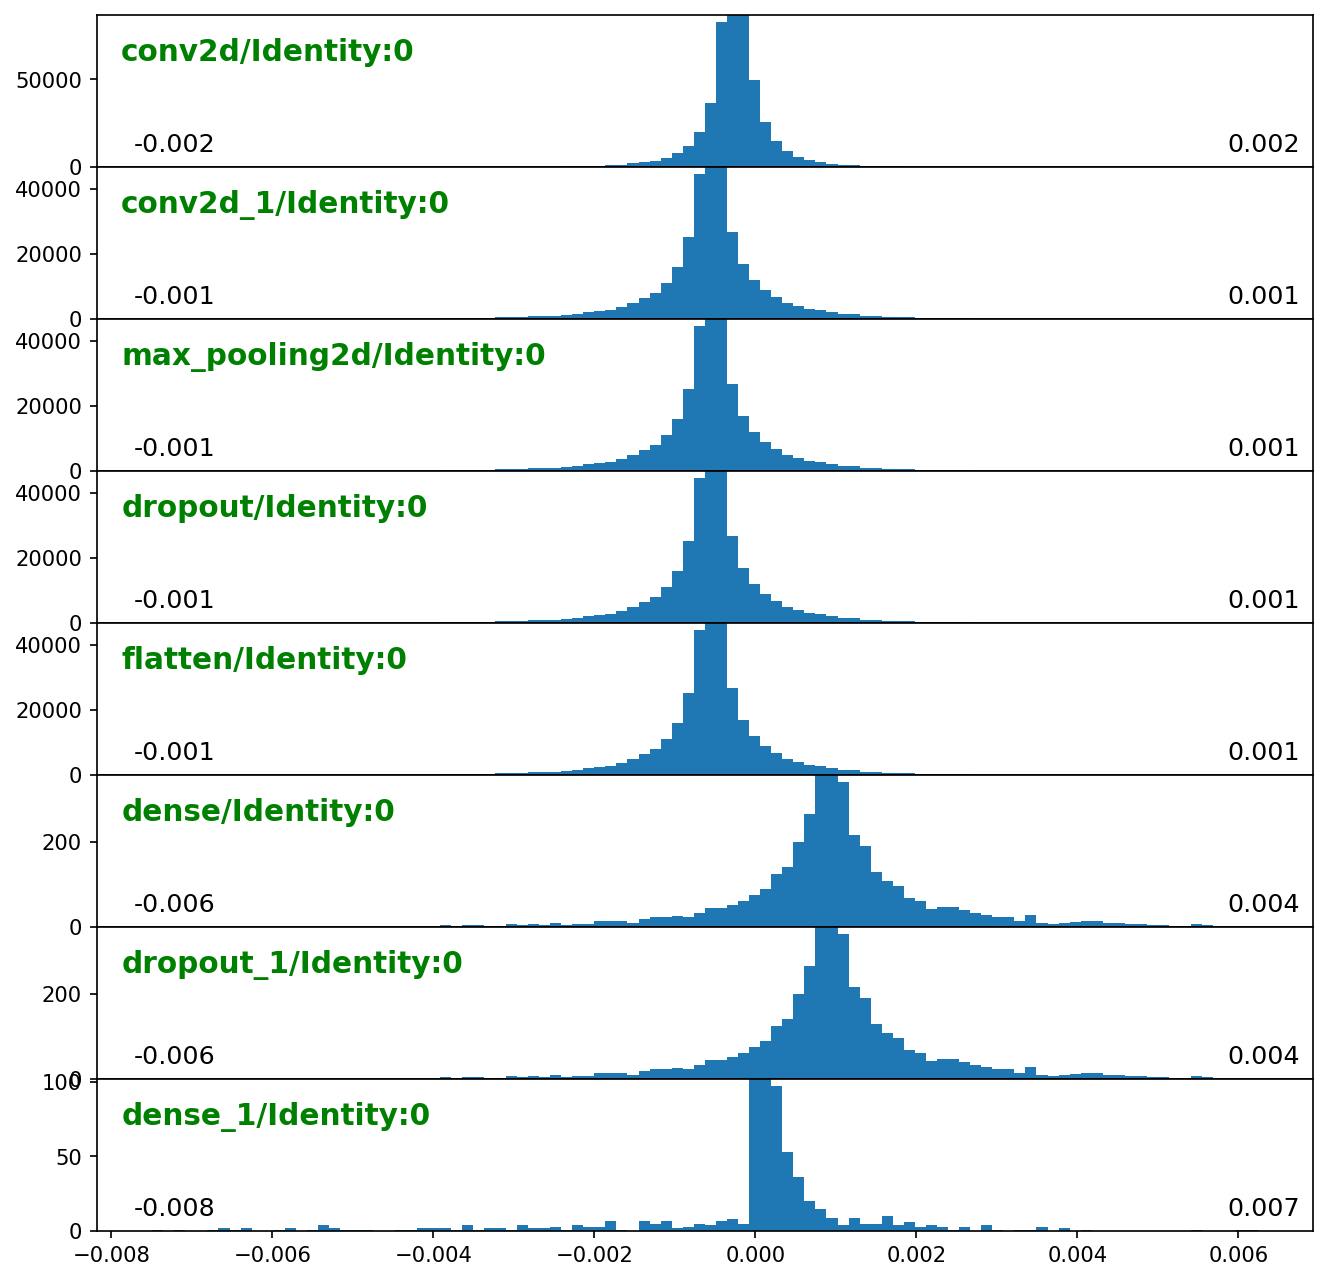

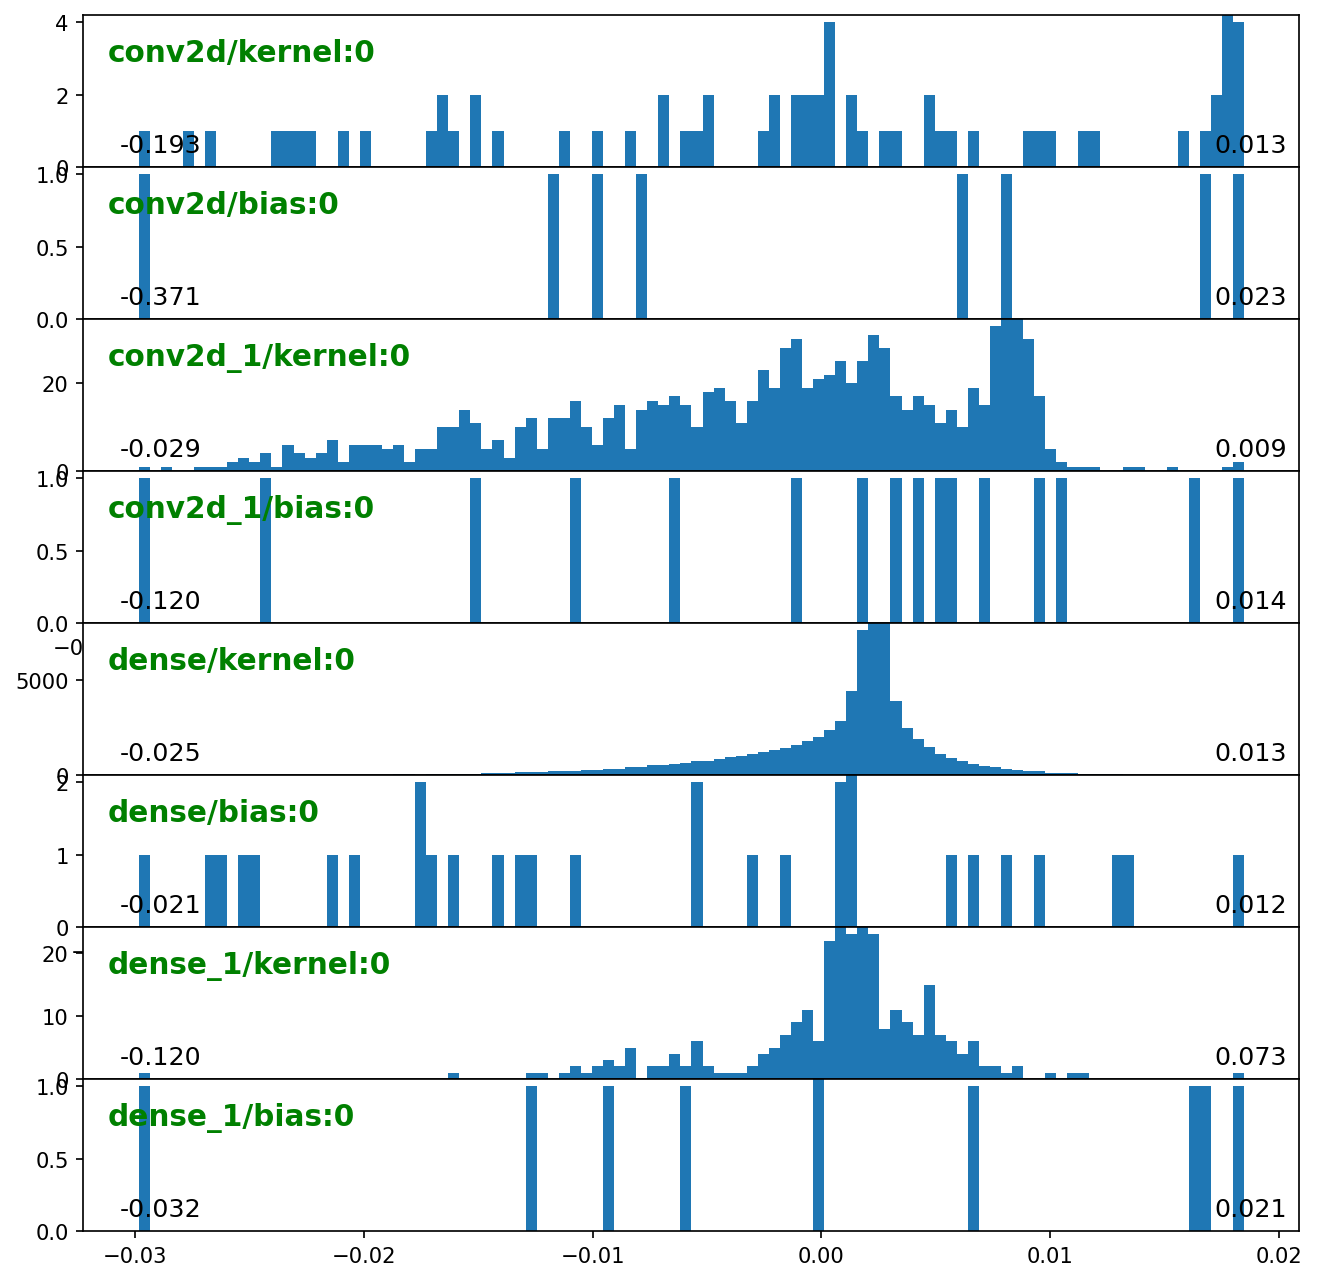

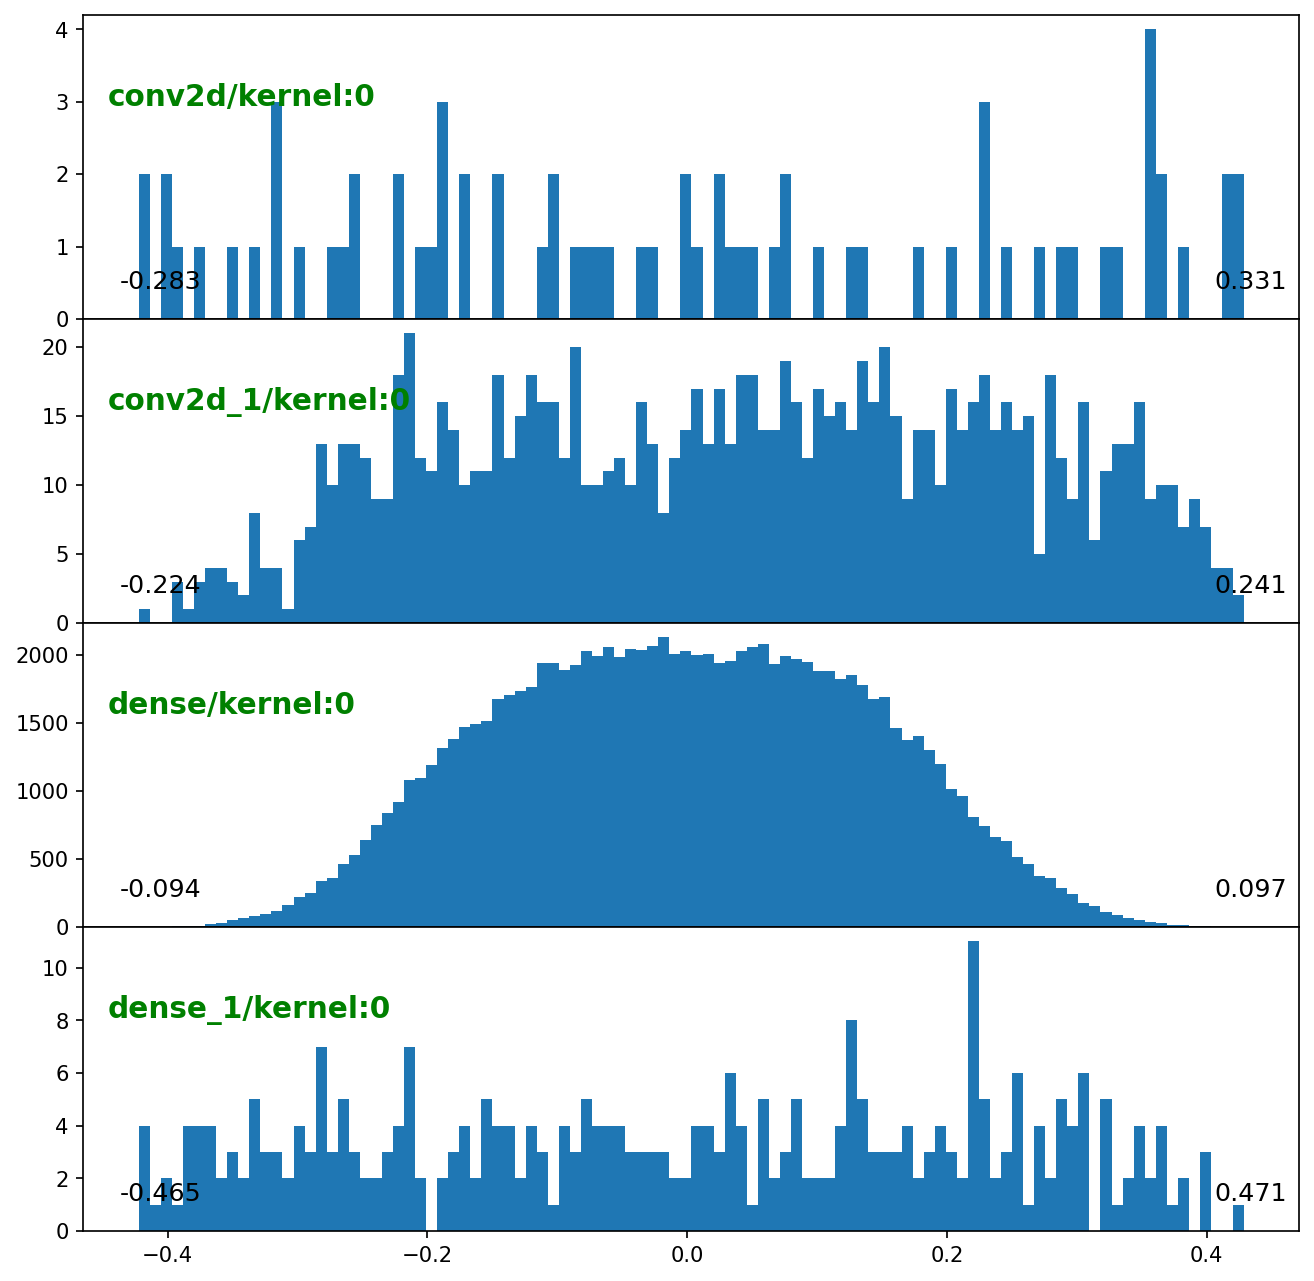

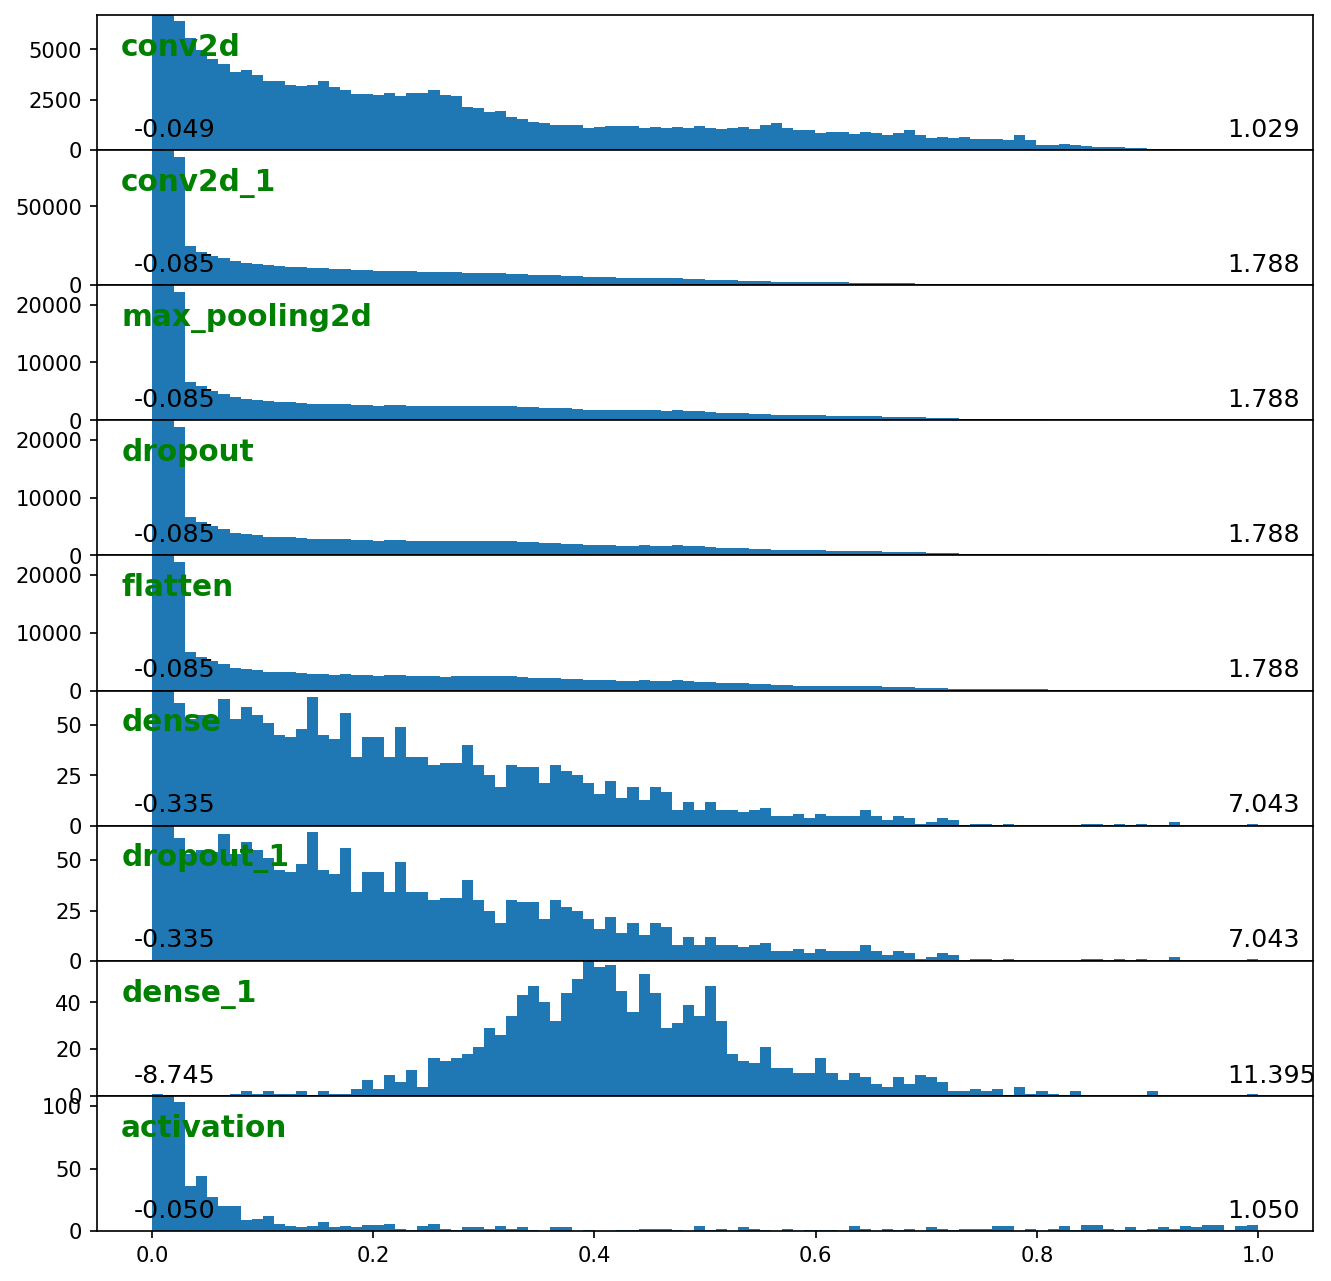


Fitting set 3...   (Loss, Acc) = (0.545295, 0.710938) 
Fitting set 16...  (Loss, Acc) = (0.659256, 0.726562) 
Fitting set 48...  (Loss, Acc) = (0.783065, 0.713542) 
Fitting set 10...  (Loss, Acc) = (0.805102, 0.722656) 
Fitting set 22...  (Loss, Acc) = (0.813933, 0.718750) 
Fitting set 30...  (Loss, Acc) = (0.807460, 0.725260) 
Fitting set 49...  (Loss, Acc) = (0.808533, 0.722098) 
Fitting set 6...   (Loss, Acc) = (0.816010, 0.716797) 
Fitting set 47...  (Loss, Acc) = (0.801368, 0.725694) 
Fitting set 15...  (Loss, Acc) = (0.792545, 0.730469) 
Fitting set 12...  (Loss, Acc) = (0.796790, 0.726562) 
Fitting set 33...  (Loss, Acc) = (0.802378, 0.725260) 
Fitting set 35...  (Loss, Acc) = (0.807989, 0.722957) 
Fitting set 27...  (Loss, Acc) = (0.801989, 0.724888) 
Fitting set 50...  (Loss, Acc) = (0.800366, 0.728646) 
Fitting set 20...  (Loss, Acc) = (0.800926, 0.728516) 
Fitting set 40...  (Loss, Acc) = (0.797602, 0.728860) 
Fitting set 39...  (Loss, Acc) = (0.798048, 0.730035) 
Fitting s

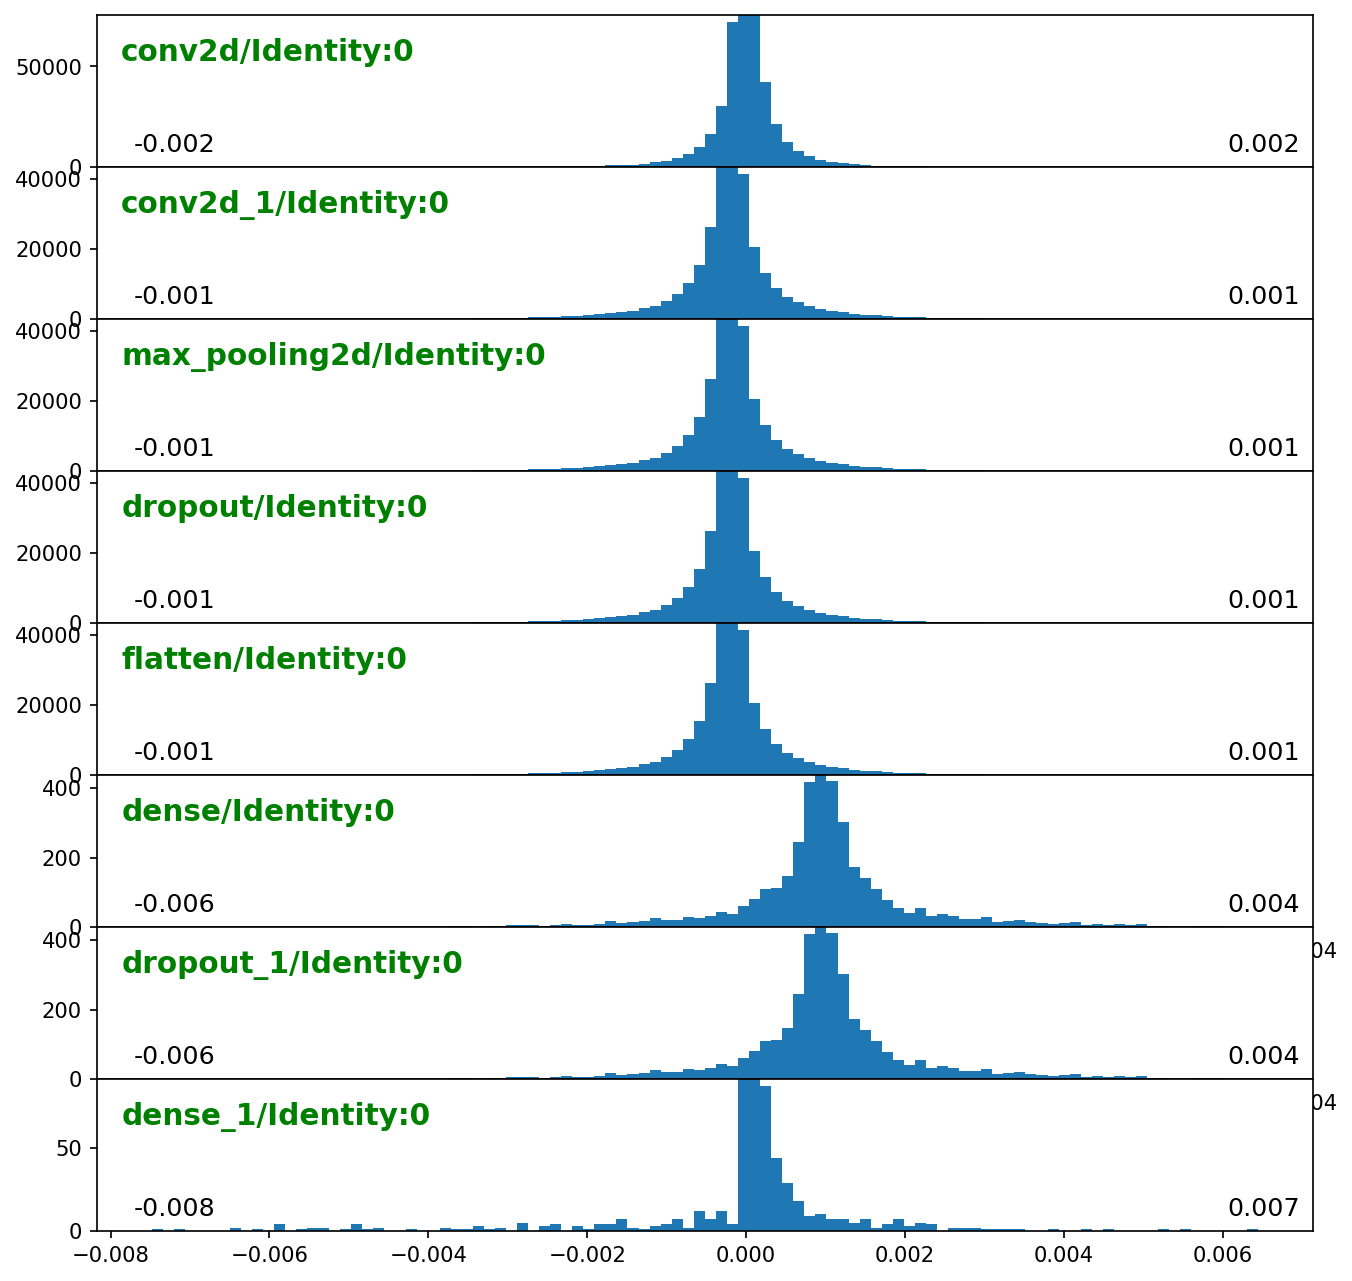

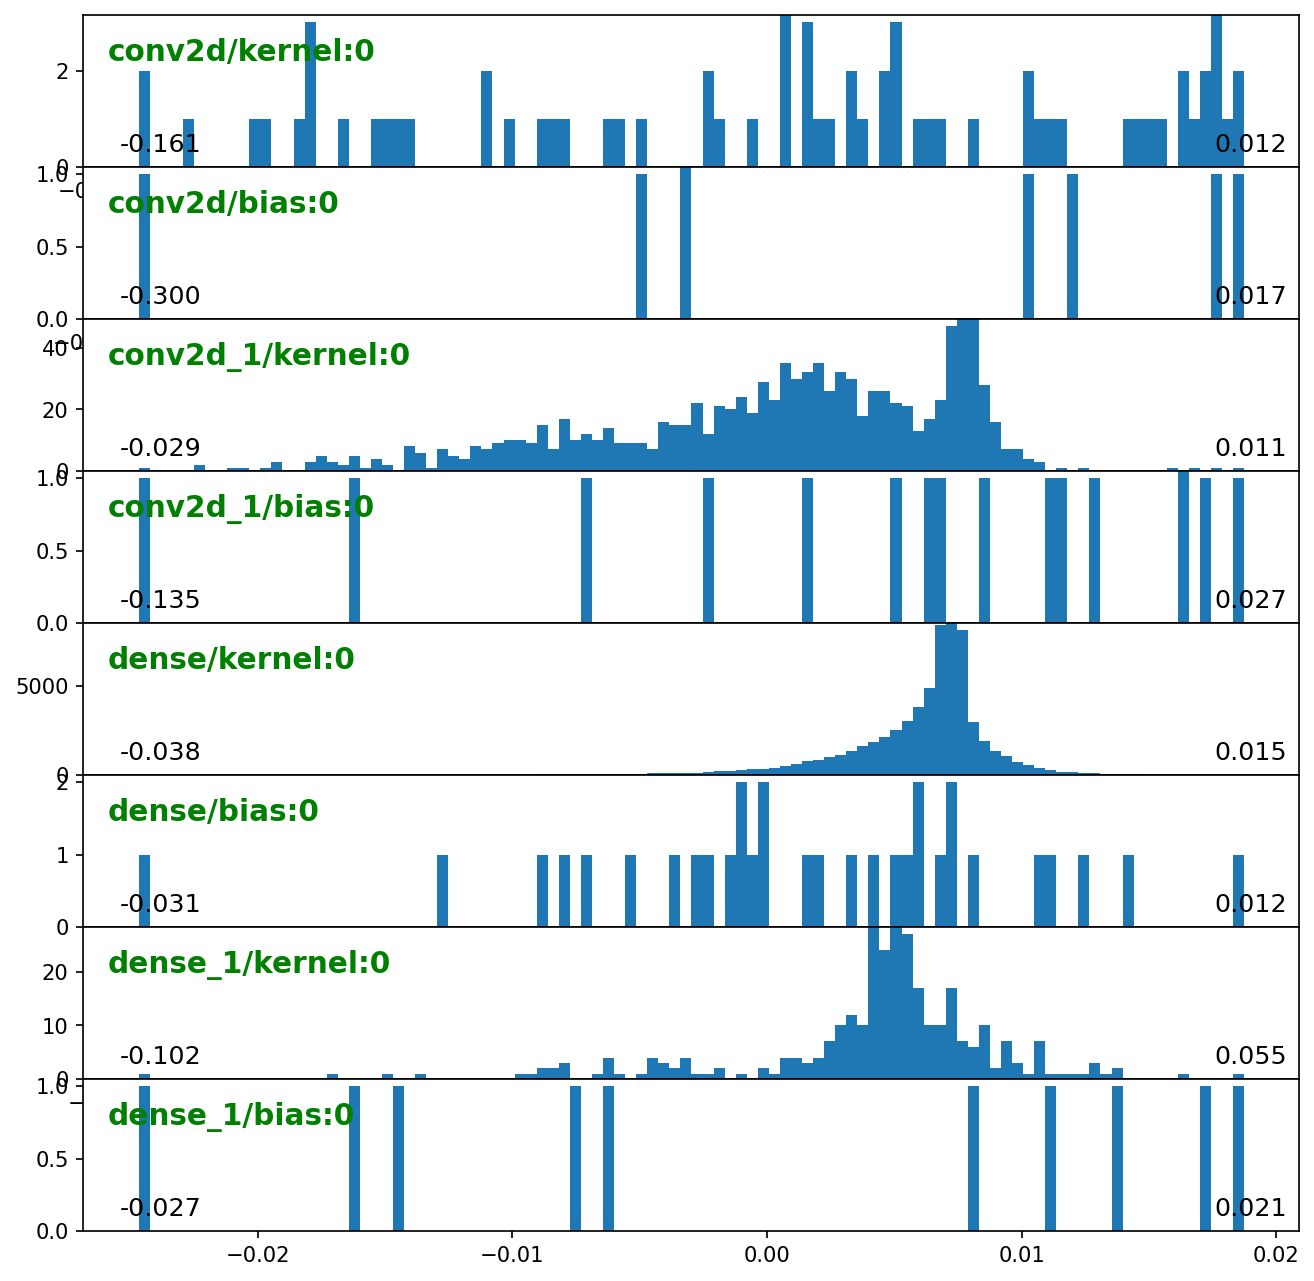



Validating...
Validating set 1...  (Loss, Acc) = (0.417043, 0.921875) 
Validating set 2...  (Loss, Acc) = (0.401897, 0.929688) 
Validating set 3...  (Loss, Acc) = (0.408868, 0.898438) 
Validating set 4...  (Loss, Acc) = (0.472556, 0.890625) 
Validating set 5...  (Loss, Acc) = (0.450203, 0.882812) 
Validating set 6...  (Loss, Acc) = (0.454737, 0.898438) 
Validating set 7...  (Loss, Acc) = (0.378316, 0.890625) 
Validating set 8...  (Loss, Acc) = (0.449982, 0.890625) 
Validating set 9...  (Loss, Acc) = (0.402403, 0.937500) 
Validating set 10... (Loss, Acc) = (0.462057, 0.882812) 
Validating set 11... (Loss, Acc) = (0.307980, 0.929688) 
Validating set 12... (Loss, Acc) = (0.439947, 0.906250) 
Validating set 13... (Loss, Acc) = (0.332681, 0.906250) 
Validating set 14... (Loss, Acc) = (0.405083, 0.914062) 
Validating set 15... (Loss, Acc) = (0.547015, 0.875000) 
Validating set 16... (Loss, Acc) = (0.470159, 0.859375) 
Validating set 17... (Loss, Acc) = (0.394130, 0.898438) 
Validating set 

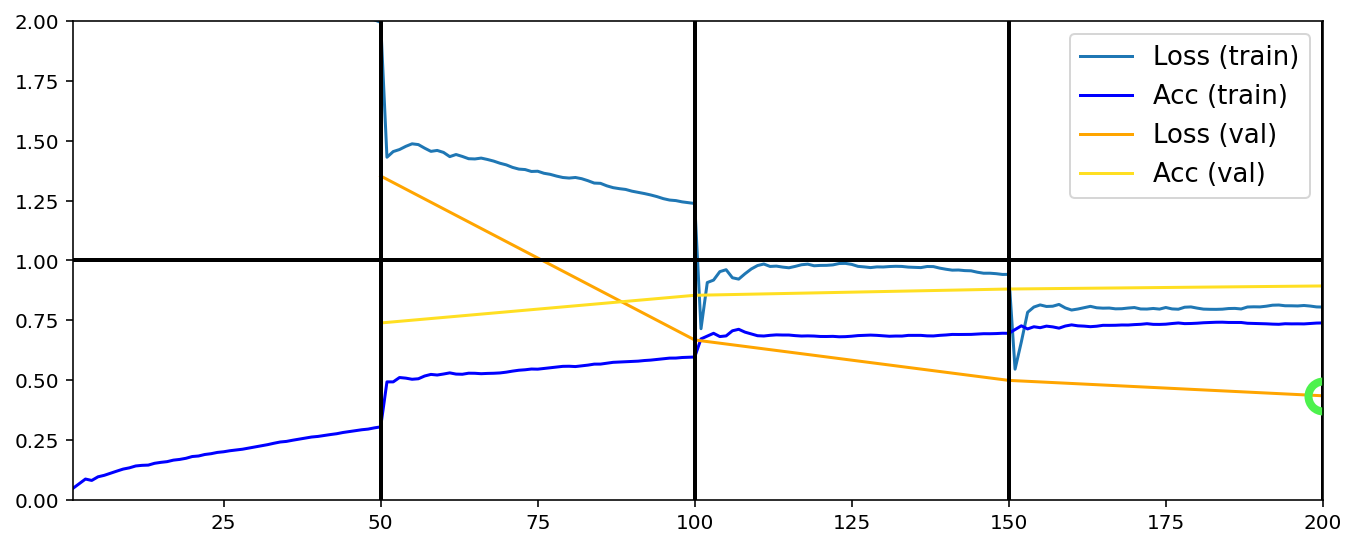

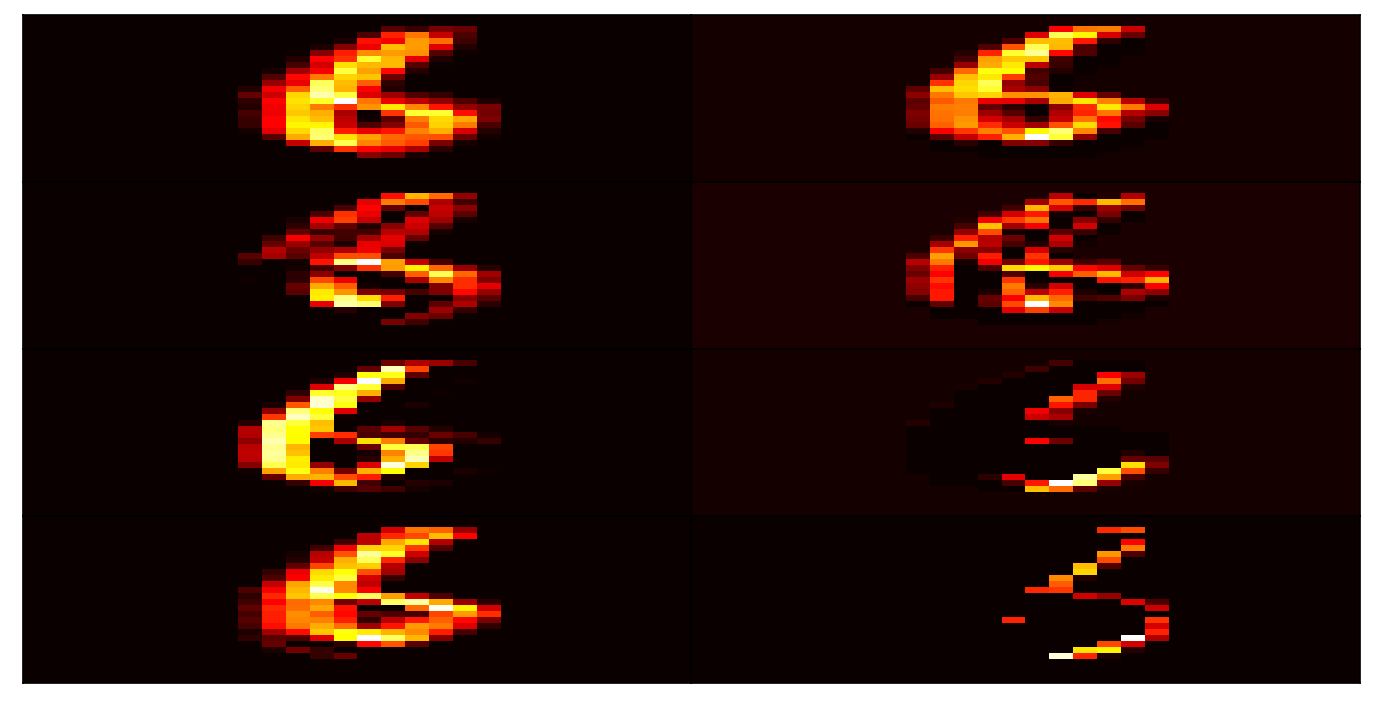

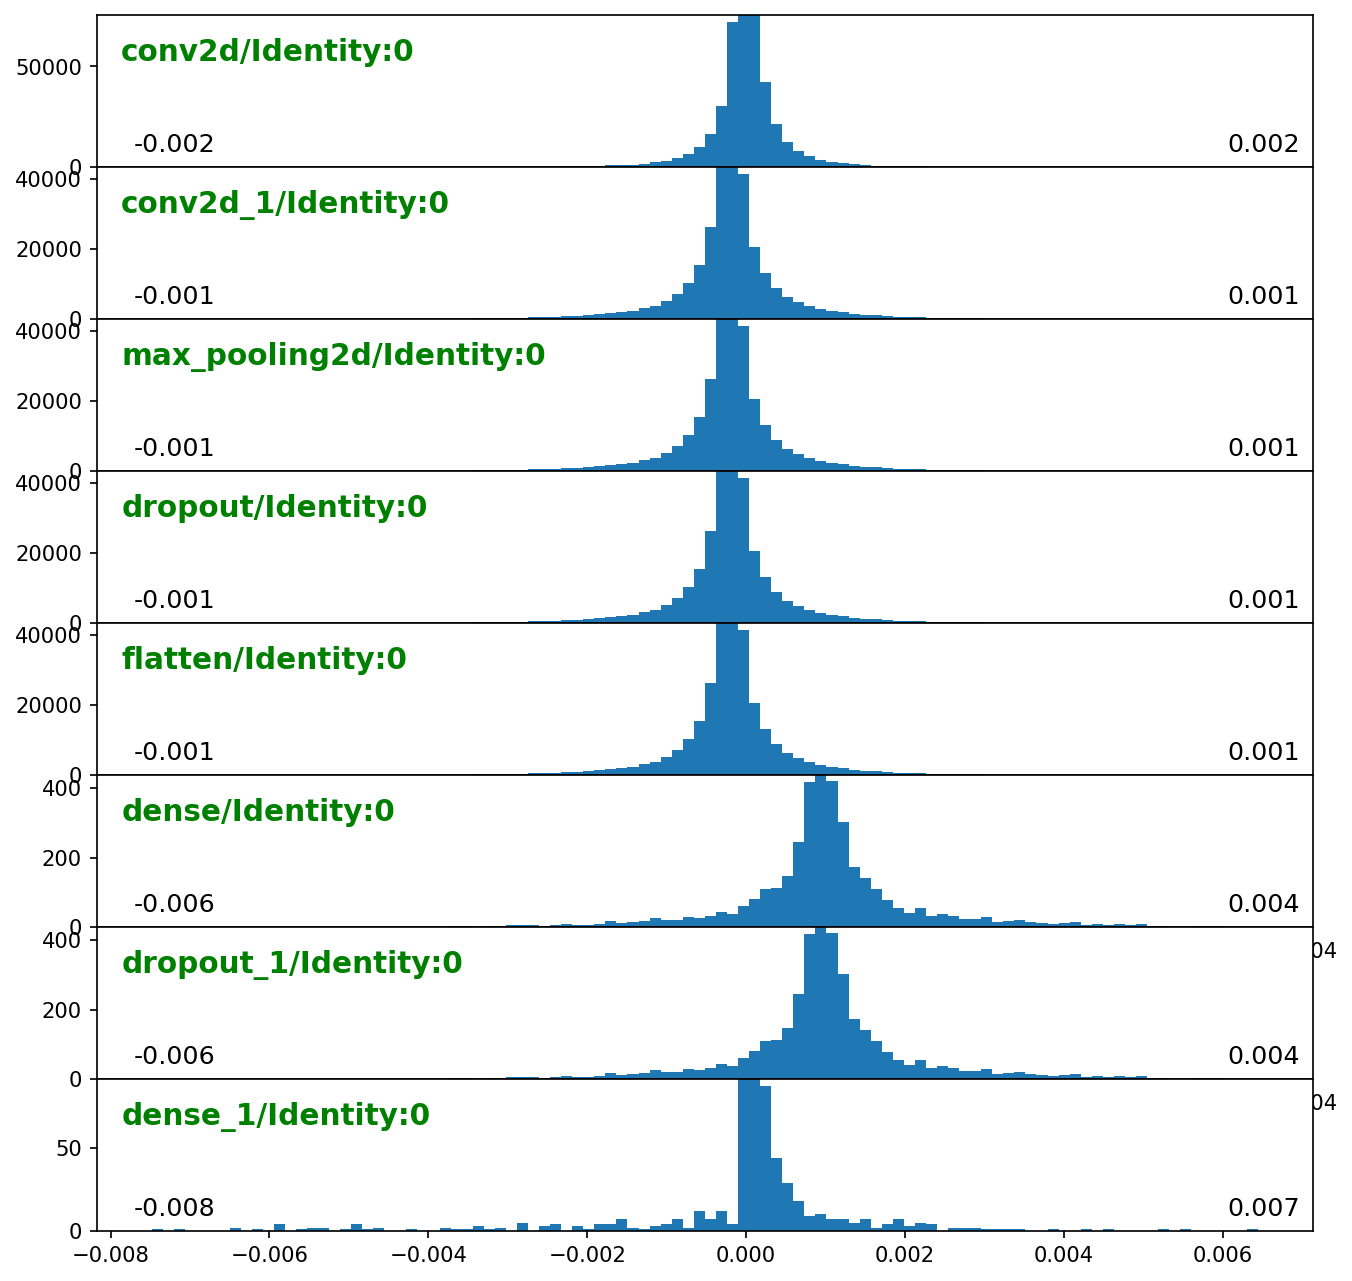

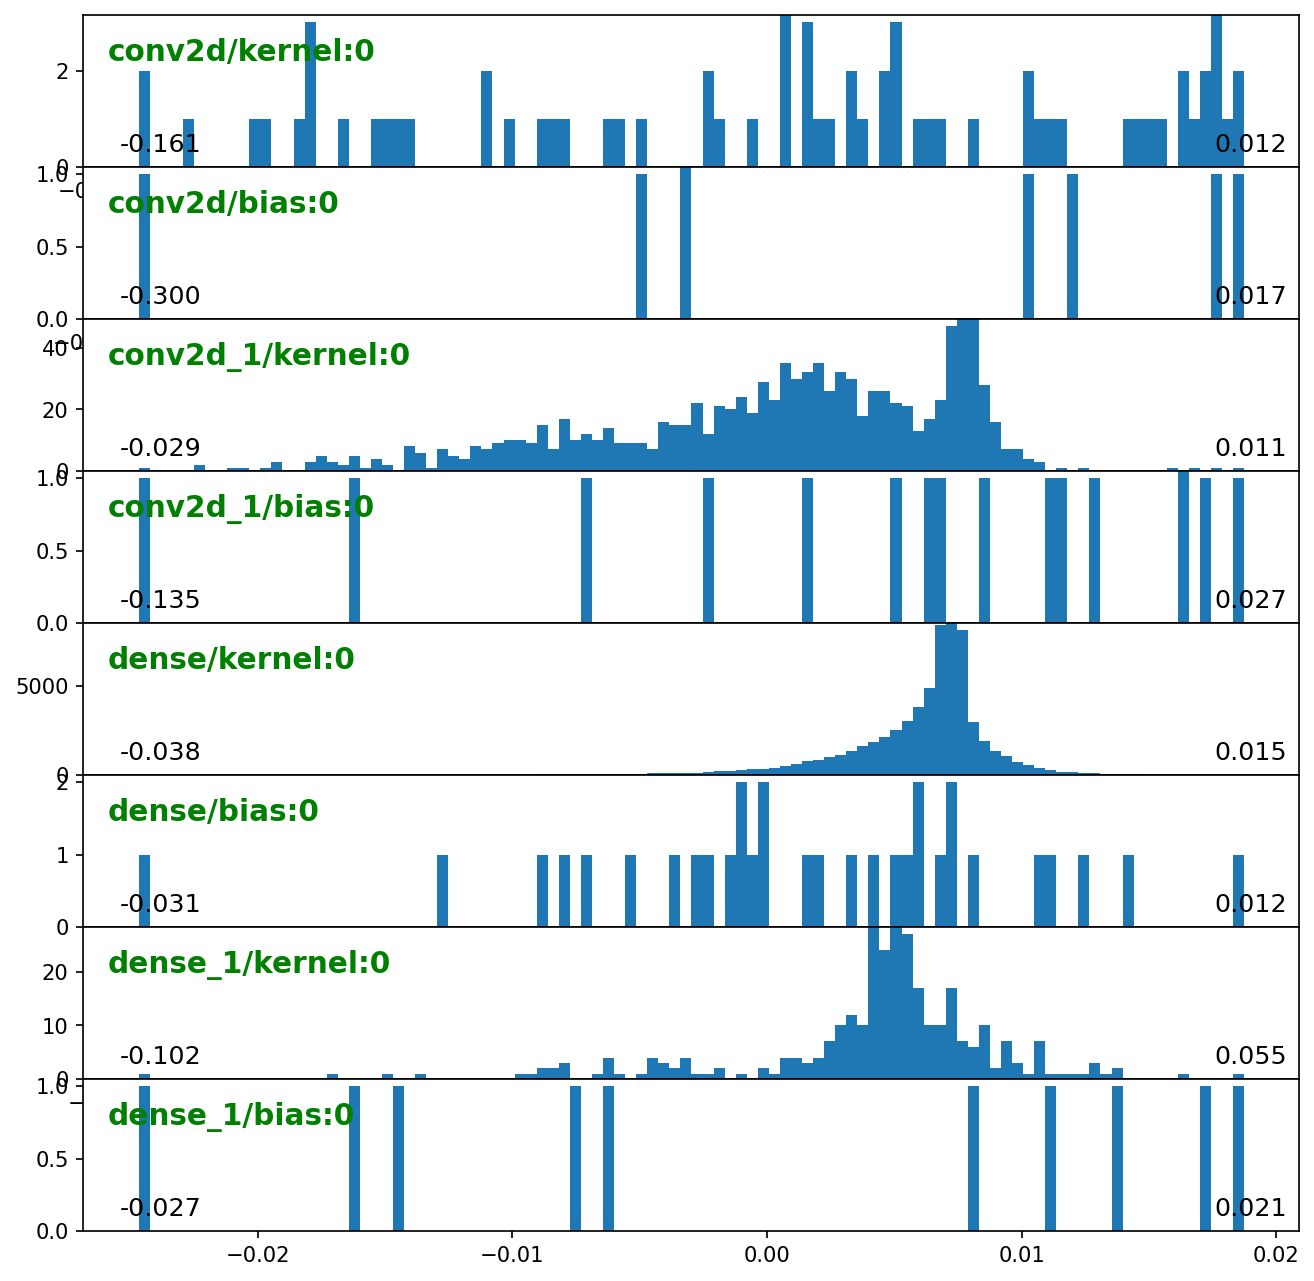

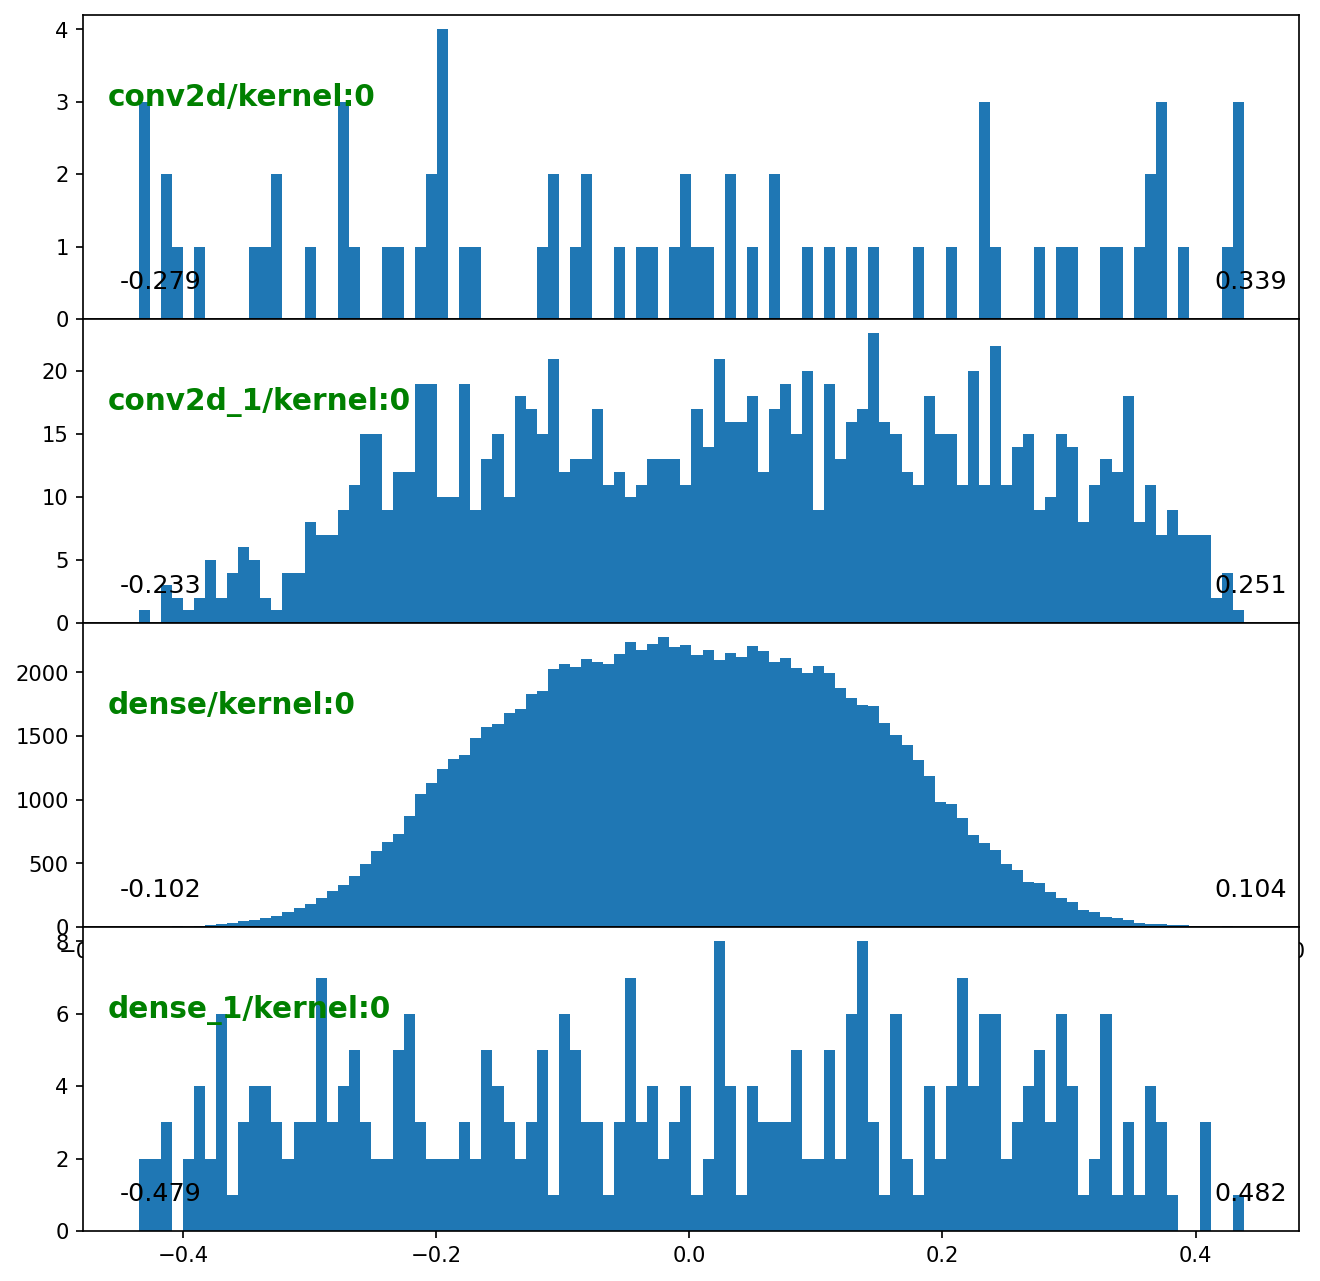

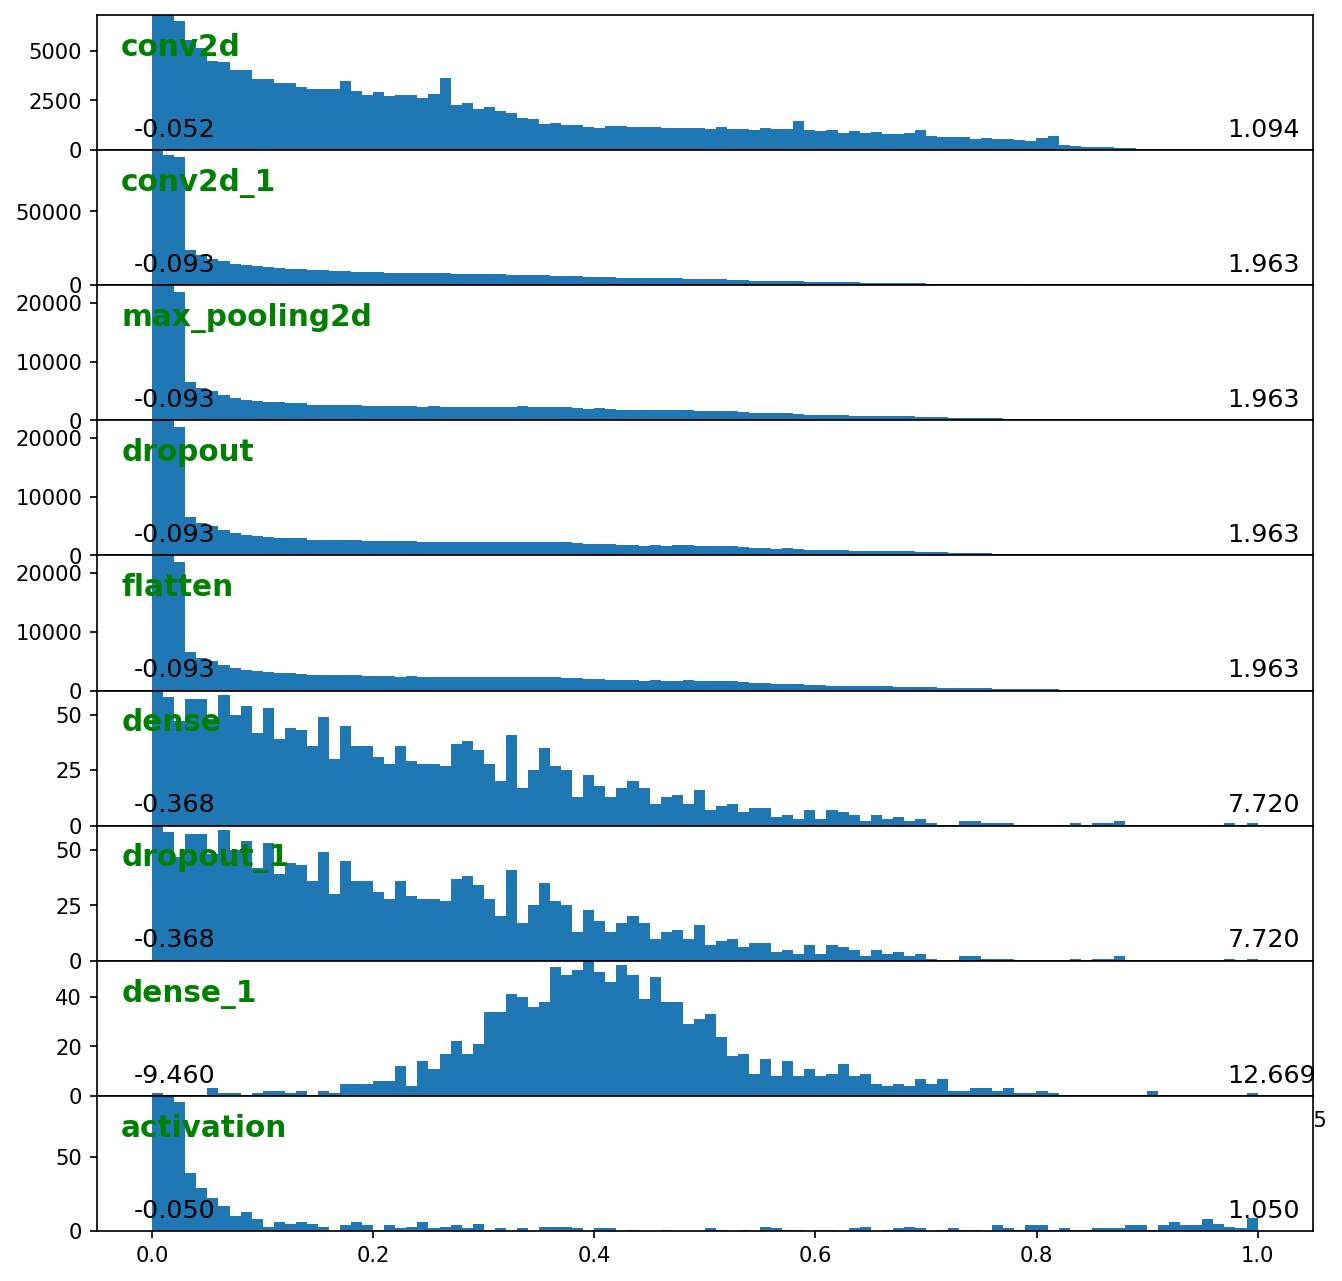

Training has concluded.


In [8]:
tg.train()

We can thus track the progression of layer gradients & activations epoch-to-epoch.